In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [30]:
df = pd.read_csv('HRP-38_database_20191021_load.csv')

# Exploration and Cleaning

In [31]:
df.head()

Date Region  Time period 0  Time period 1  Time period 2  \
0  01/01/2030     D1      79.270247      72.529177      67.599140   
1  02/01/2030     D1      80.941032      74.059523      69.026778   
2  03/01/2030     D1      82.726080      75.772485      70.687020   
3  04/01/2030     D1      80.941032      74.059523      69.026778   
4  05/01/2030     D1      78.434854      71.764004      66.885322   

   Time period 3  Time period 4  Time period 5  Time period 6  Time period 7  \
0      65.888719      63.172169      60.355005      61.260522      63.071556   
1      67.280723      64.507577      61.631723      62.556105      64.404868   
2      68.922675      66.120480      63.214500      64.148565      66.016695   
3      67.280723      64.507577      61.631723      62.556105      64.404868   
4      65.192718      62.504464      59.716646      60.612731      62.404899   

   ...  Time period 17  Time period 18  Time period 19  Time period 20  \
0  ...       79.169634       79.873925       84.300897       90.538902   
1  ...       80.838323       81.557287       86.076487       92.444451   
2  ...       82.622295       83.348790       87.915330       94.350000   
3  ...       80.838323       81.557287       86.076487       92.444451   
4  ...       78.335289       79.032244       83.413101       89.586127   

   Time period 21  Time period 22  Time period 23  Minimum load level (p.u.)  \
0       89.532772       87.319286       85.407639                  60.355005   
1       91.417360       89.157760       87.206287                  61.631723   
2       93.312150       91.028880       89.056965                  63.214500   
3       91.417360       89.157760       87.206287                  61.631723   
4       88.590478       86.400049       84.508316                  59.716646   

   Maximum load level (p.u.)  Peak-valley difference  
0                  90.538902               30.183897  
1                  92.444451               30.812728  
2                  94.350000               31.135500  
3                  92.444451               30.812728  
4                  89.586127               29.869481  

[5 rows x 29 columns]

In [32]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [33]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [34]:
df.dtypes

Date                         datetime64[ns]
Region                               object
Time period 0                       float64
Time period 1                       float64
Time period 2                       float64
Time period 3                       float64
Time period 4                       float64
Time period 5                       float64
Time period 6                       float64
Time period 7                       float64
Time period 8                       float64
Time period 9                       float64
Time period 10                      float64
Time period 11                      float64
Time period 12                      float64
Time period 13                      float64
Time period 14                      float64
Time period 15                      float64
Time period 16                      float64
Time period 17                      float64
Time period 18                      float64
Time period 19                      float64
Time period 20                  

In [35]:
df.Region.unique()

array(['D1', 'D2', 'D3', 'D4', 'D5'], dtype=object)

In [36]:
regions = ['D1', 'D2', 'D3', 'D4', 'D5']

In [37]:
df2 = pd.get_dummies(df['Region'])
df = pd.concat([df, df2], axis=1)

In [38]:
X = df.drop(columns=['Date', 'Minimum load level (p.u.)', 'Maximum load level (p.u.)', 'Peak-valley difference'])

In [39]:
df.isna().sum().sum()

0

# Visualization

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
X_viz = X.drop(columns=['Year', 'Month', 'Day'])
X_viz_list = [X_viz[X_viz[r] == 1].reset_index(drop=True) for r in regions]

In [42]:
for i in X_viz_list:
   print(i.shape)

(365, 30)
(365, 30)
(365, 30)
(365, 30)
(365, 30)


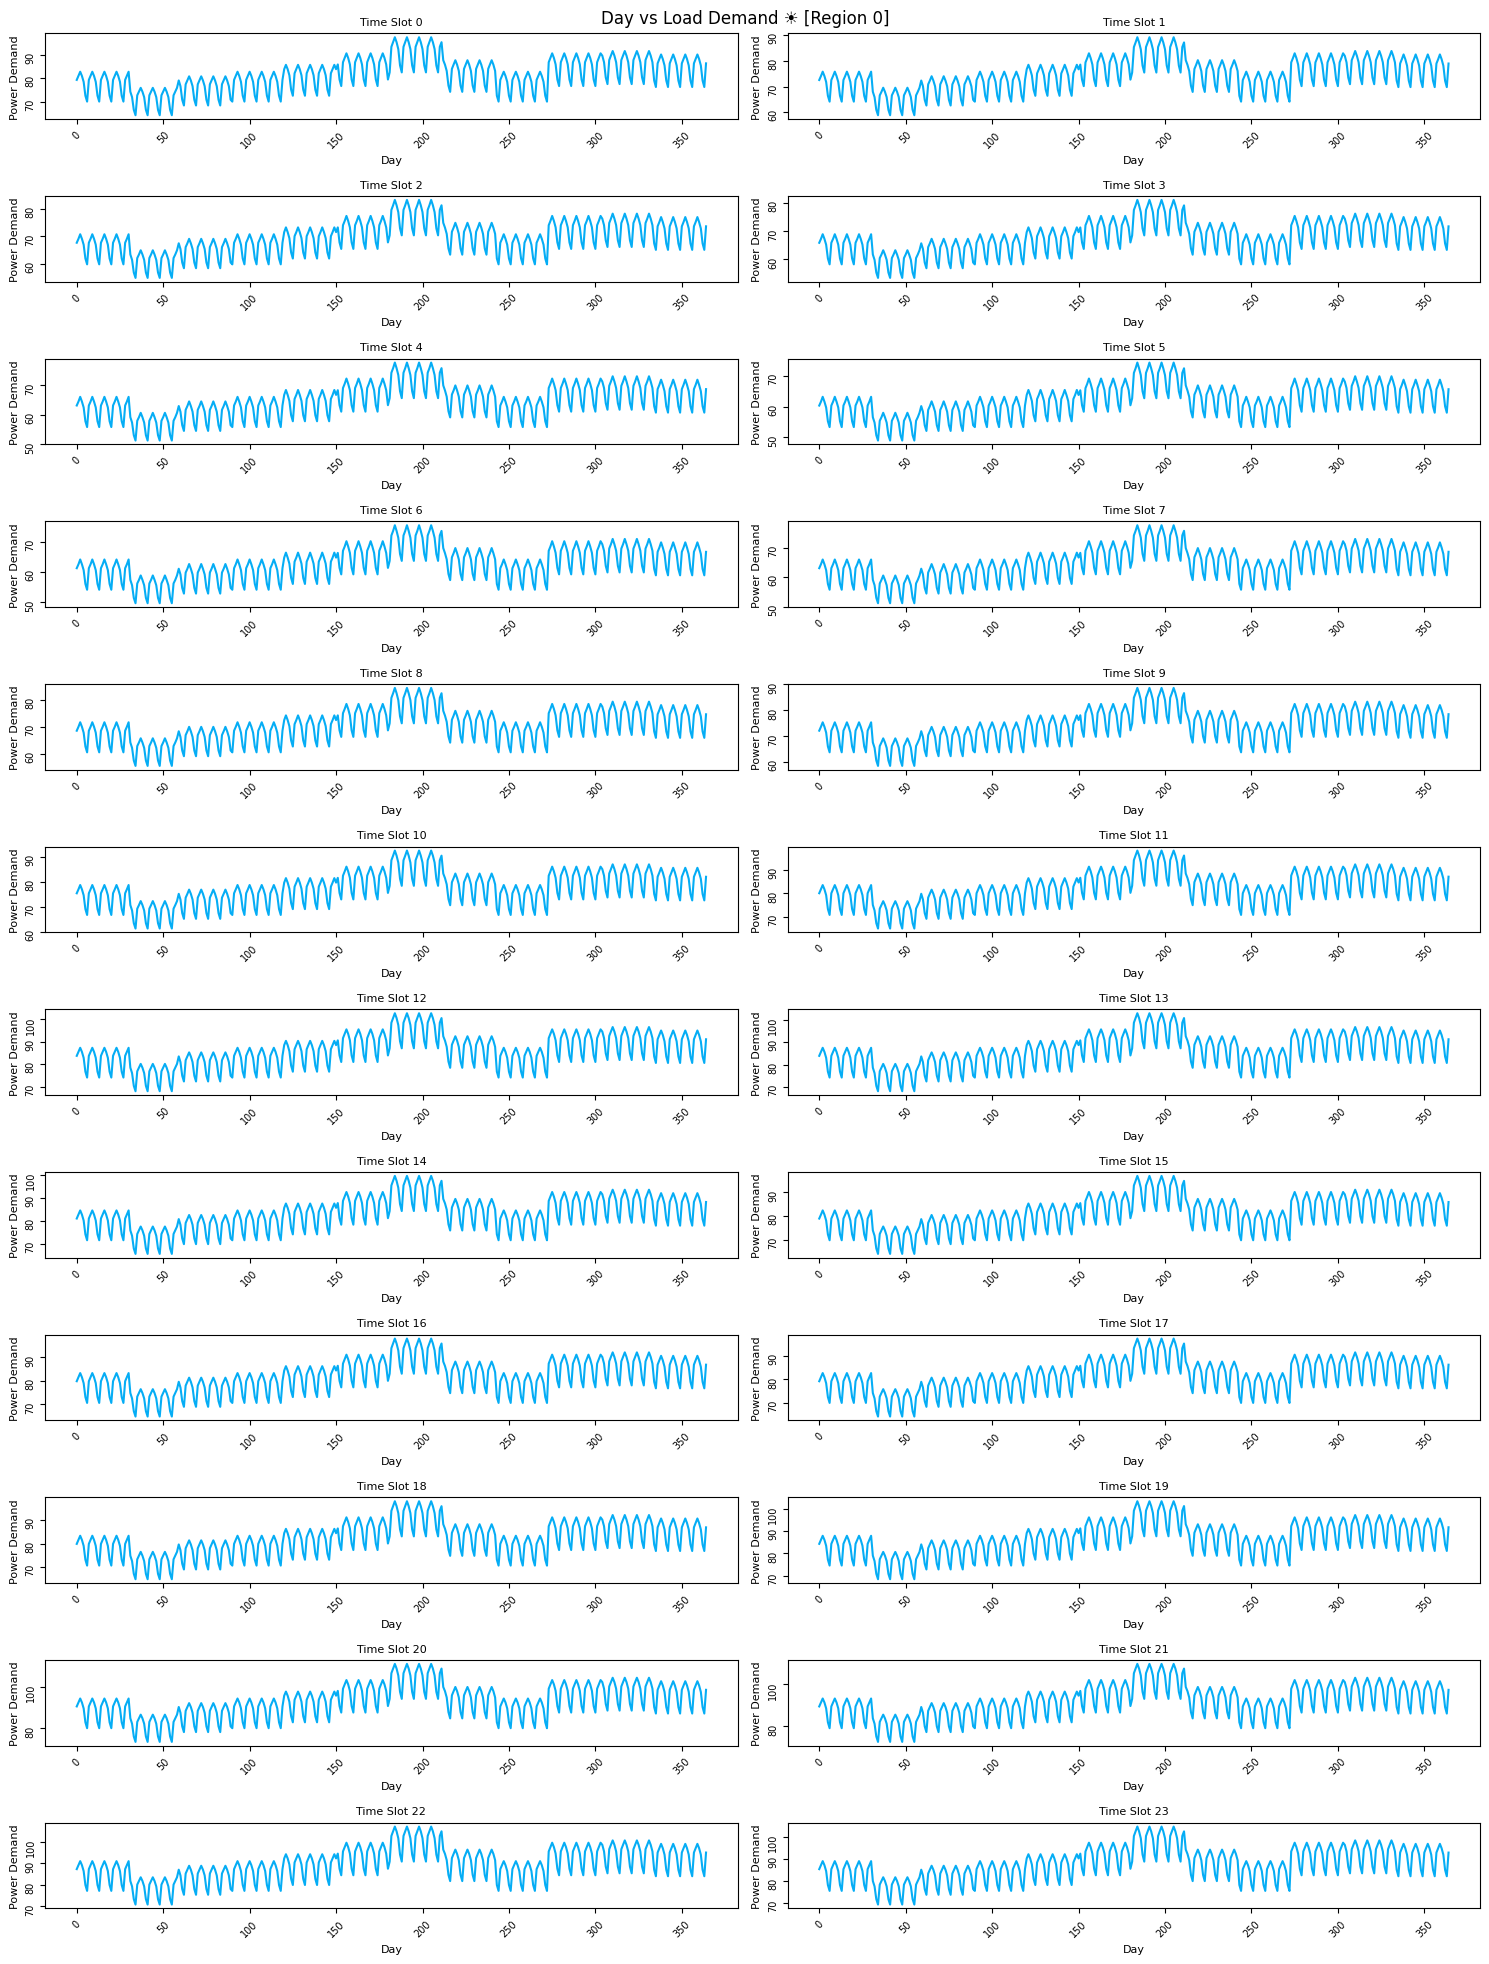

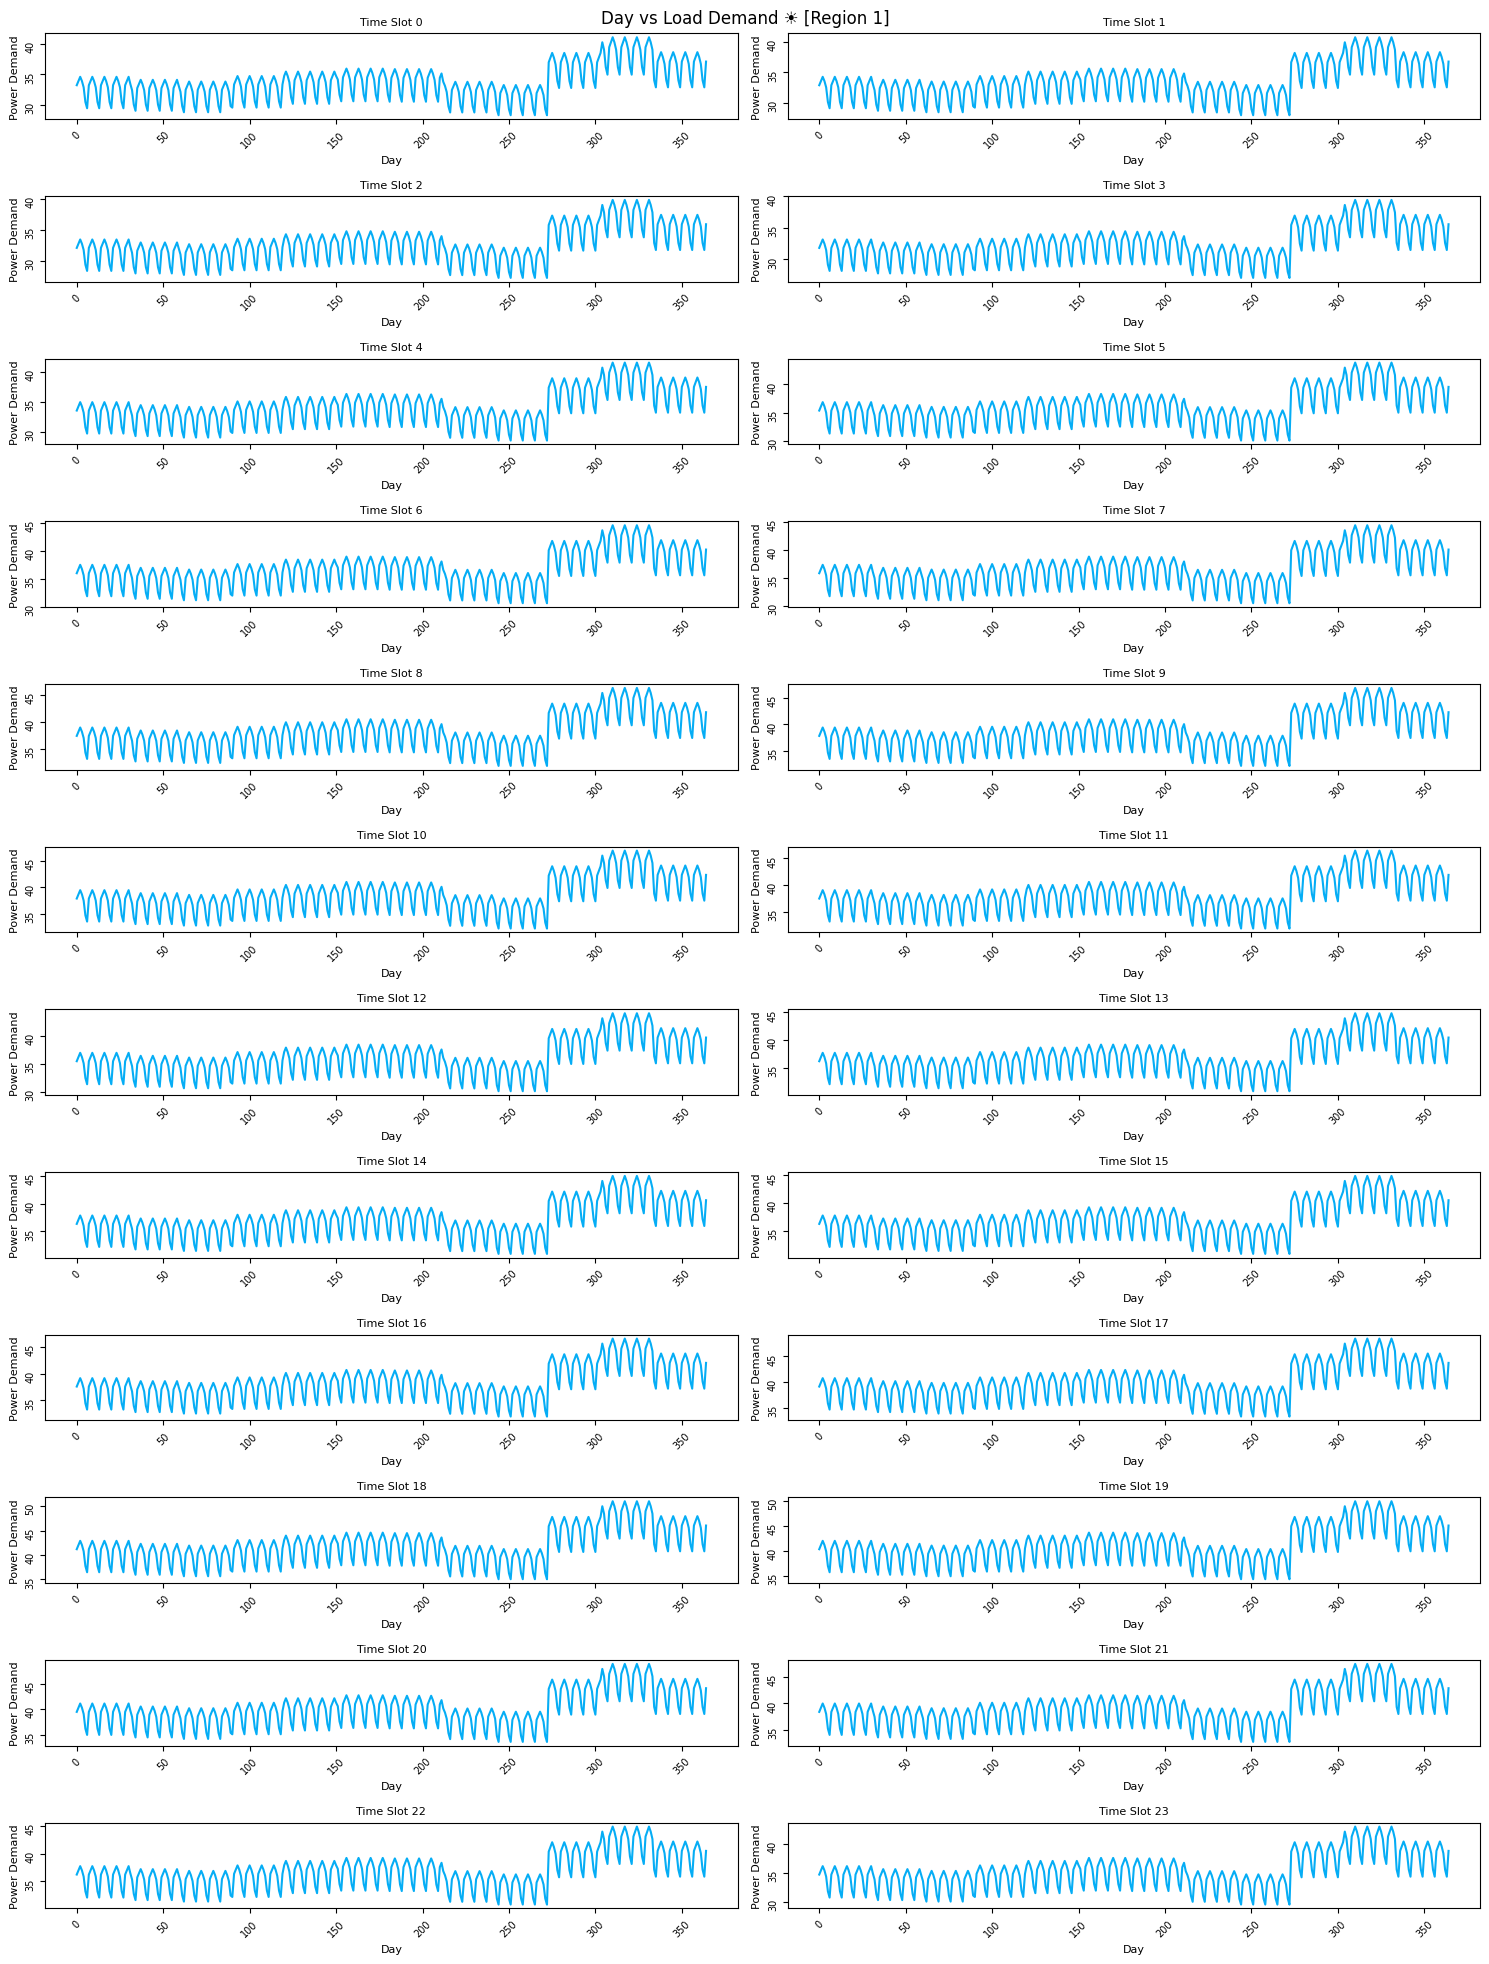

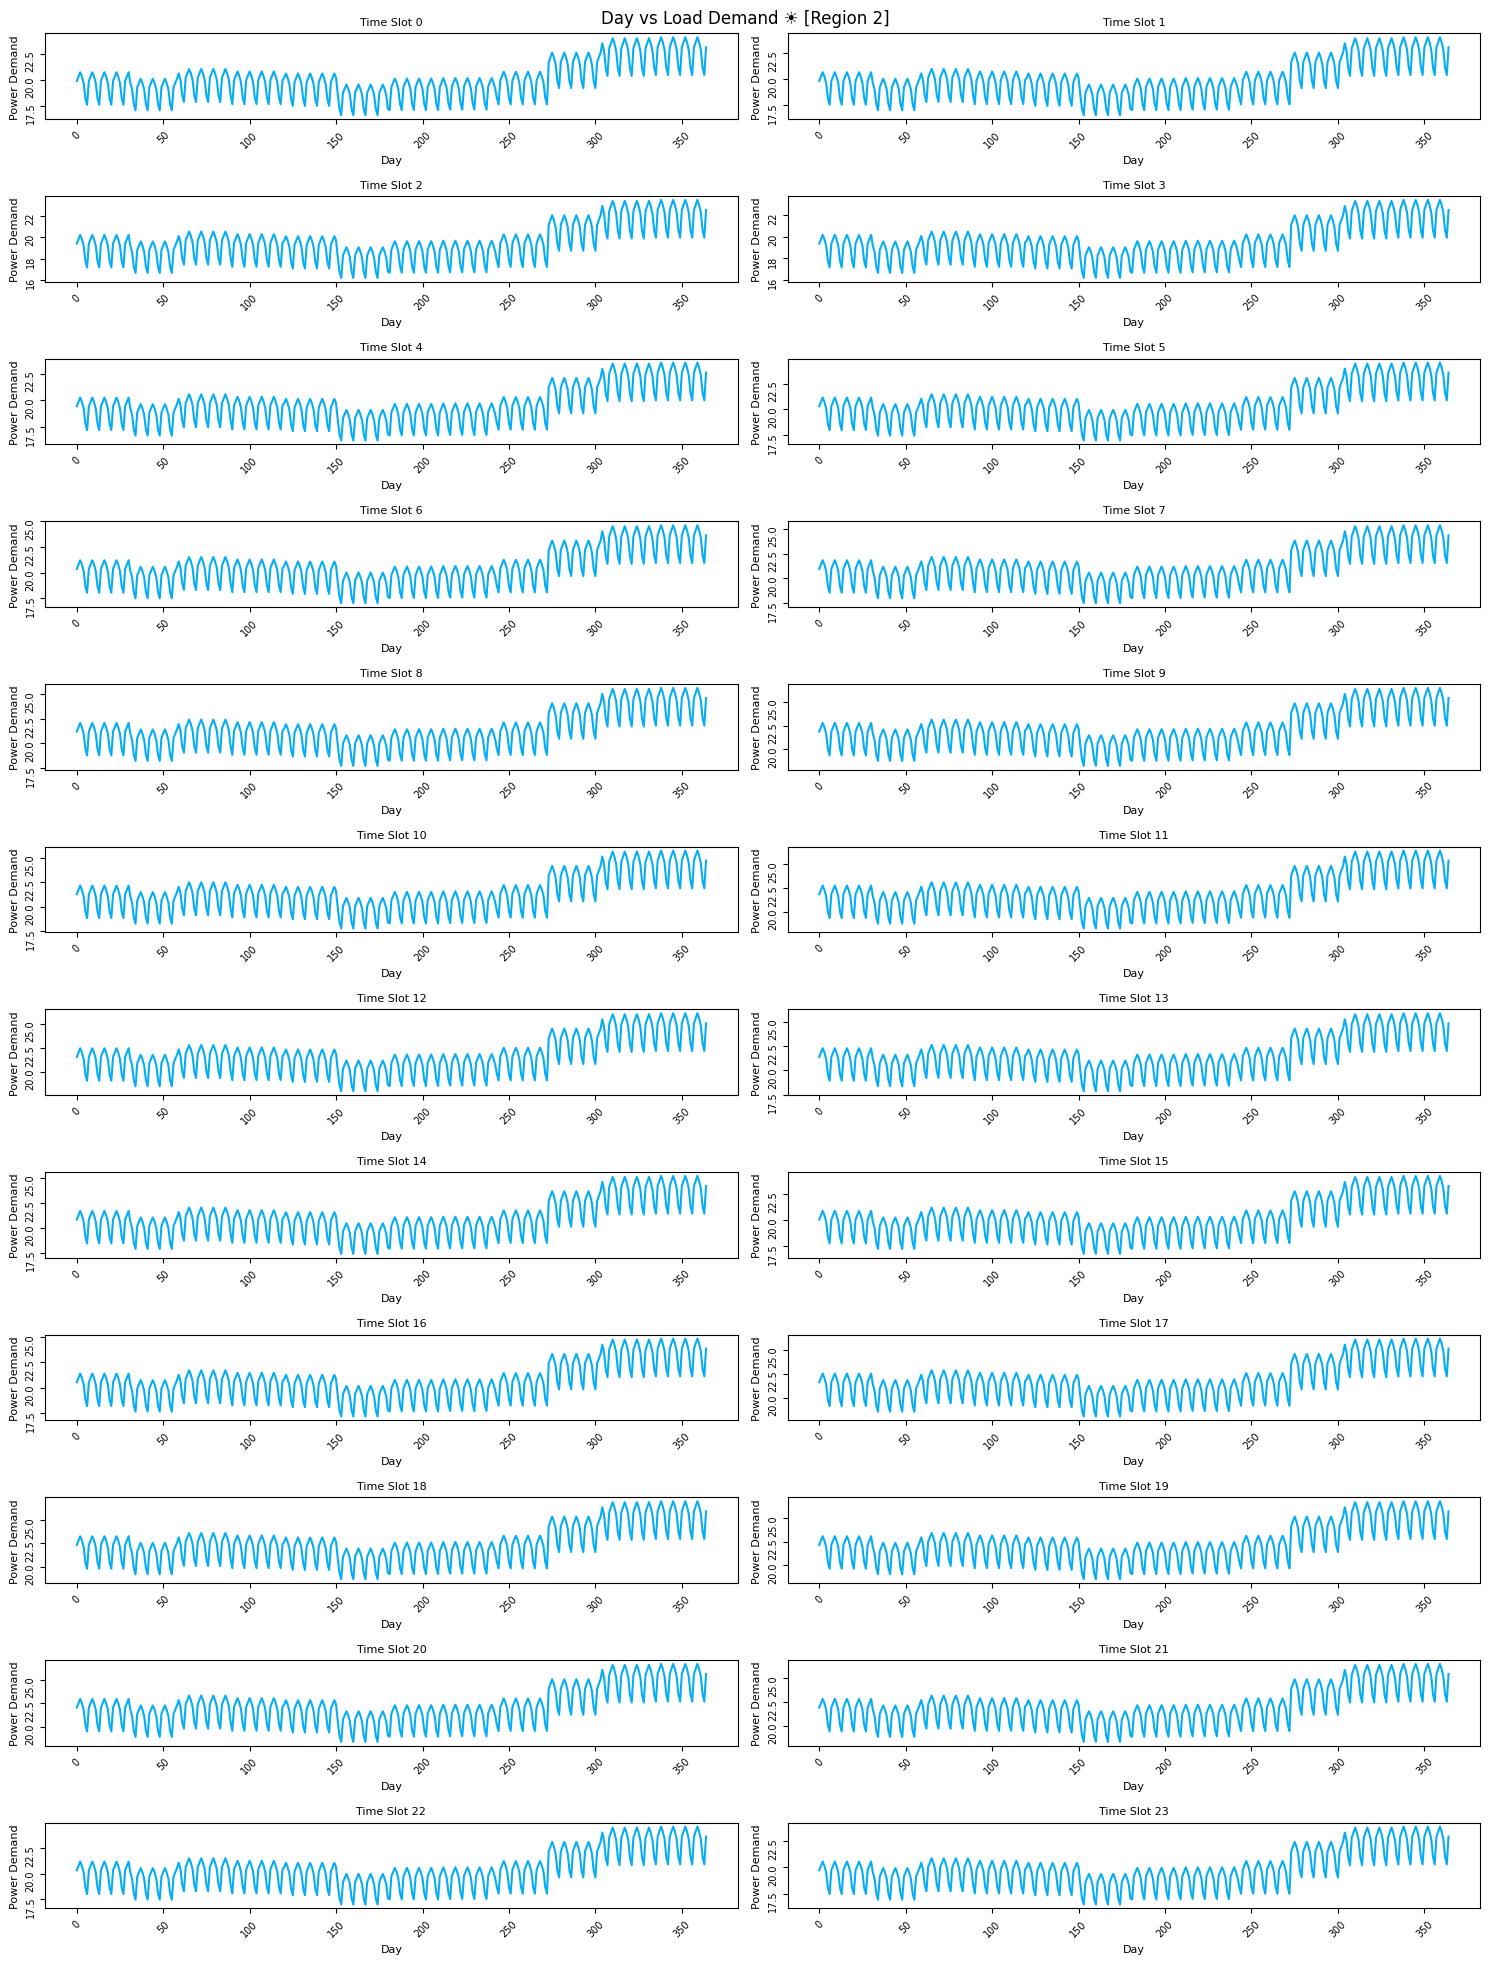

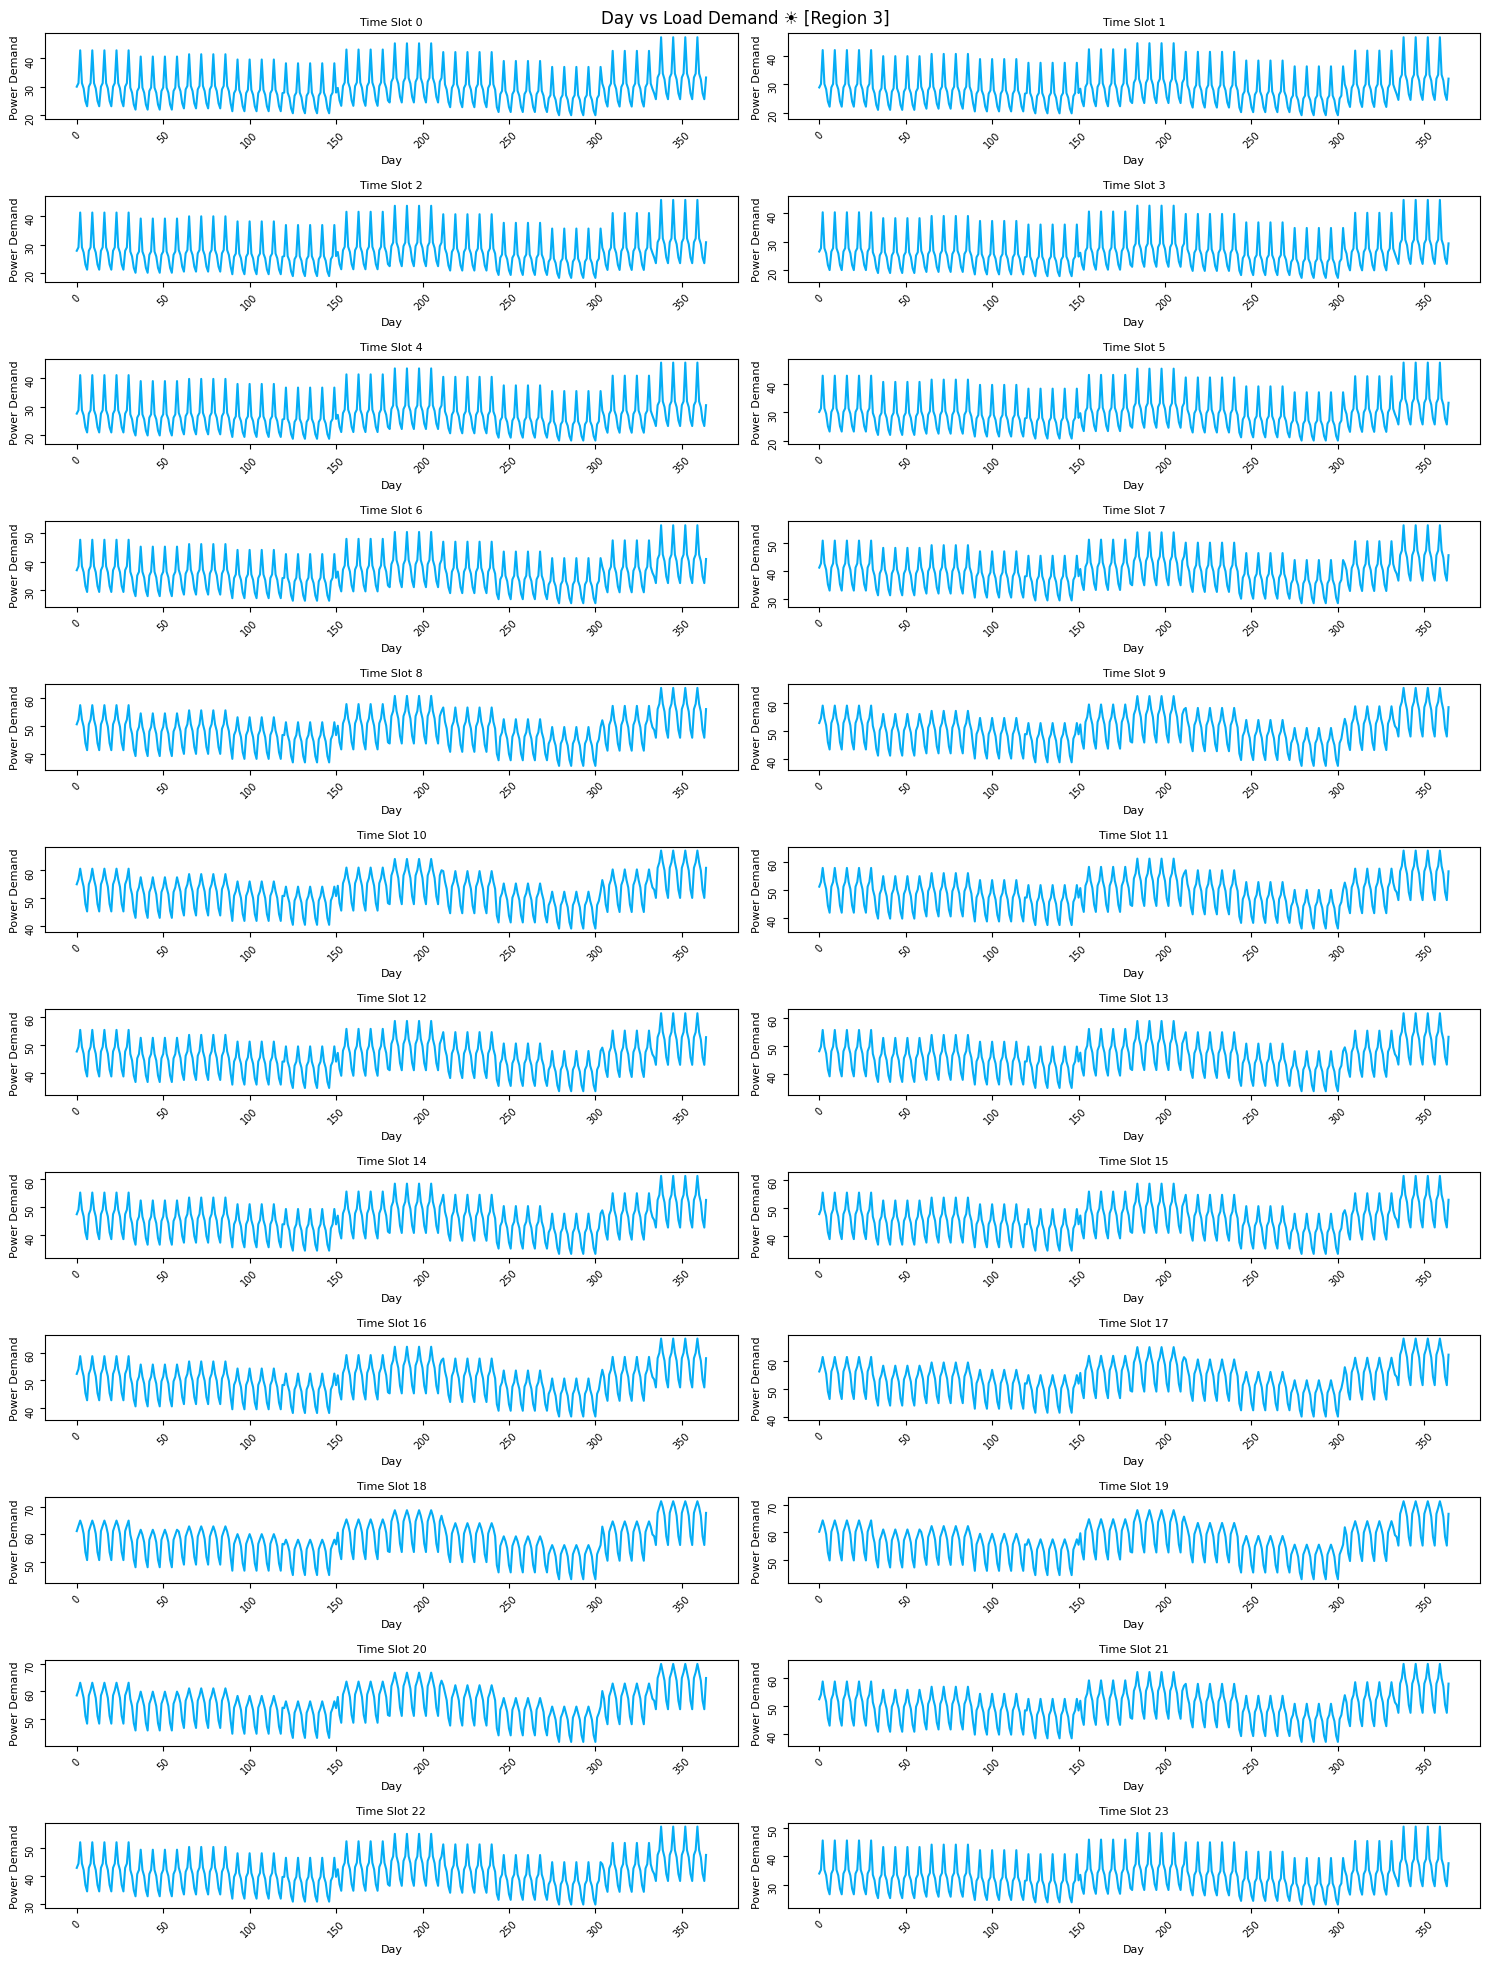

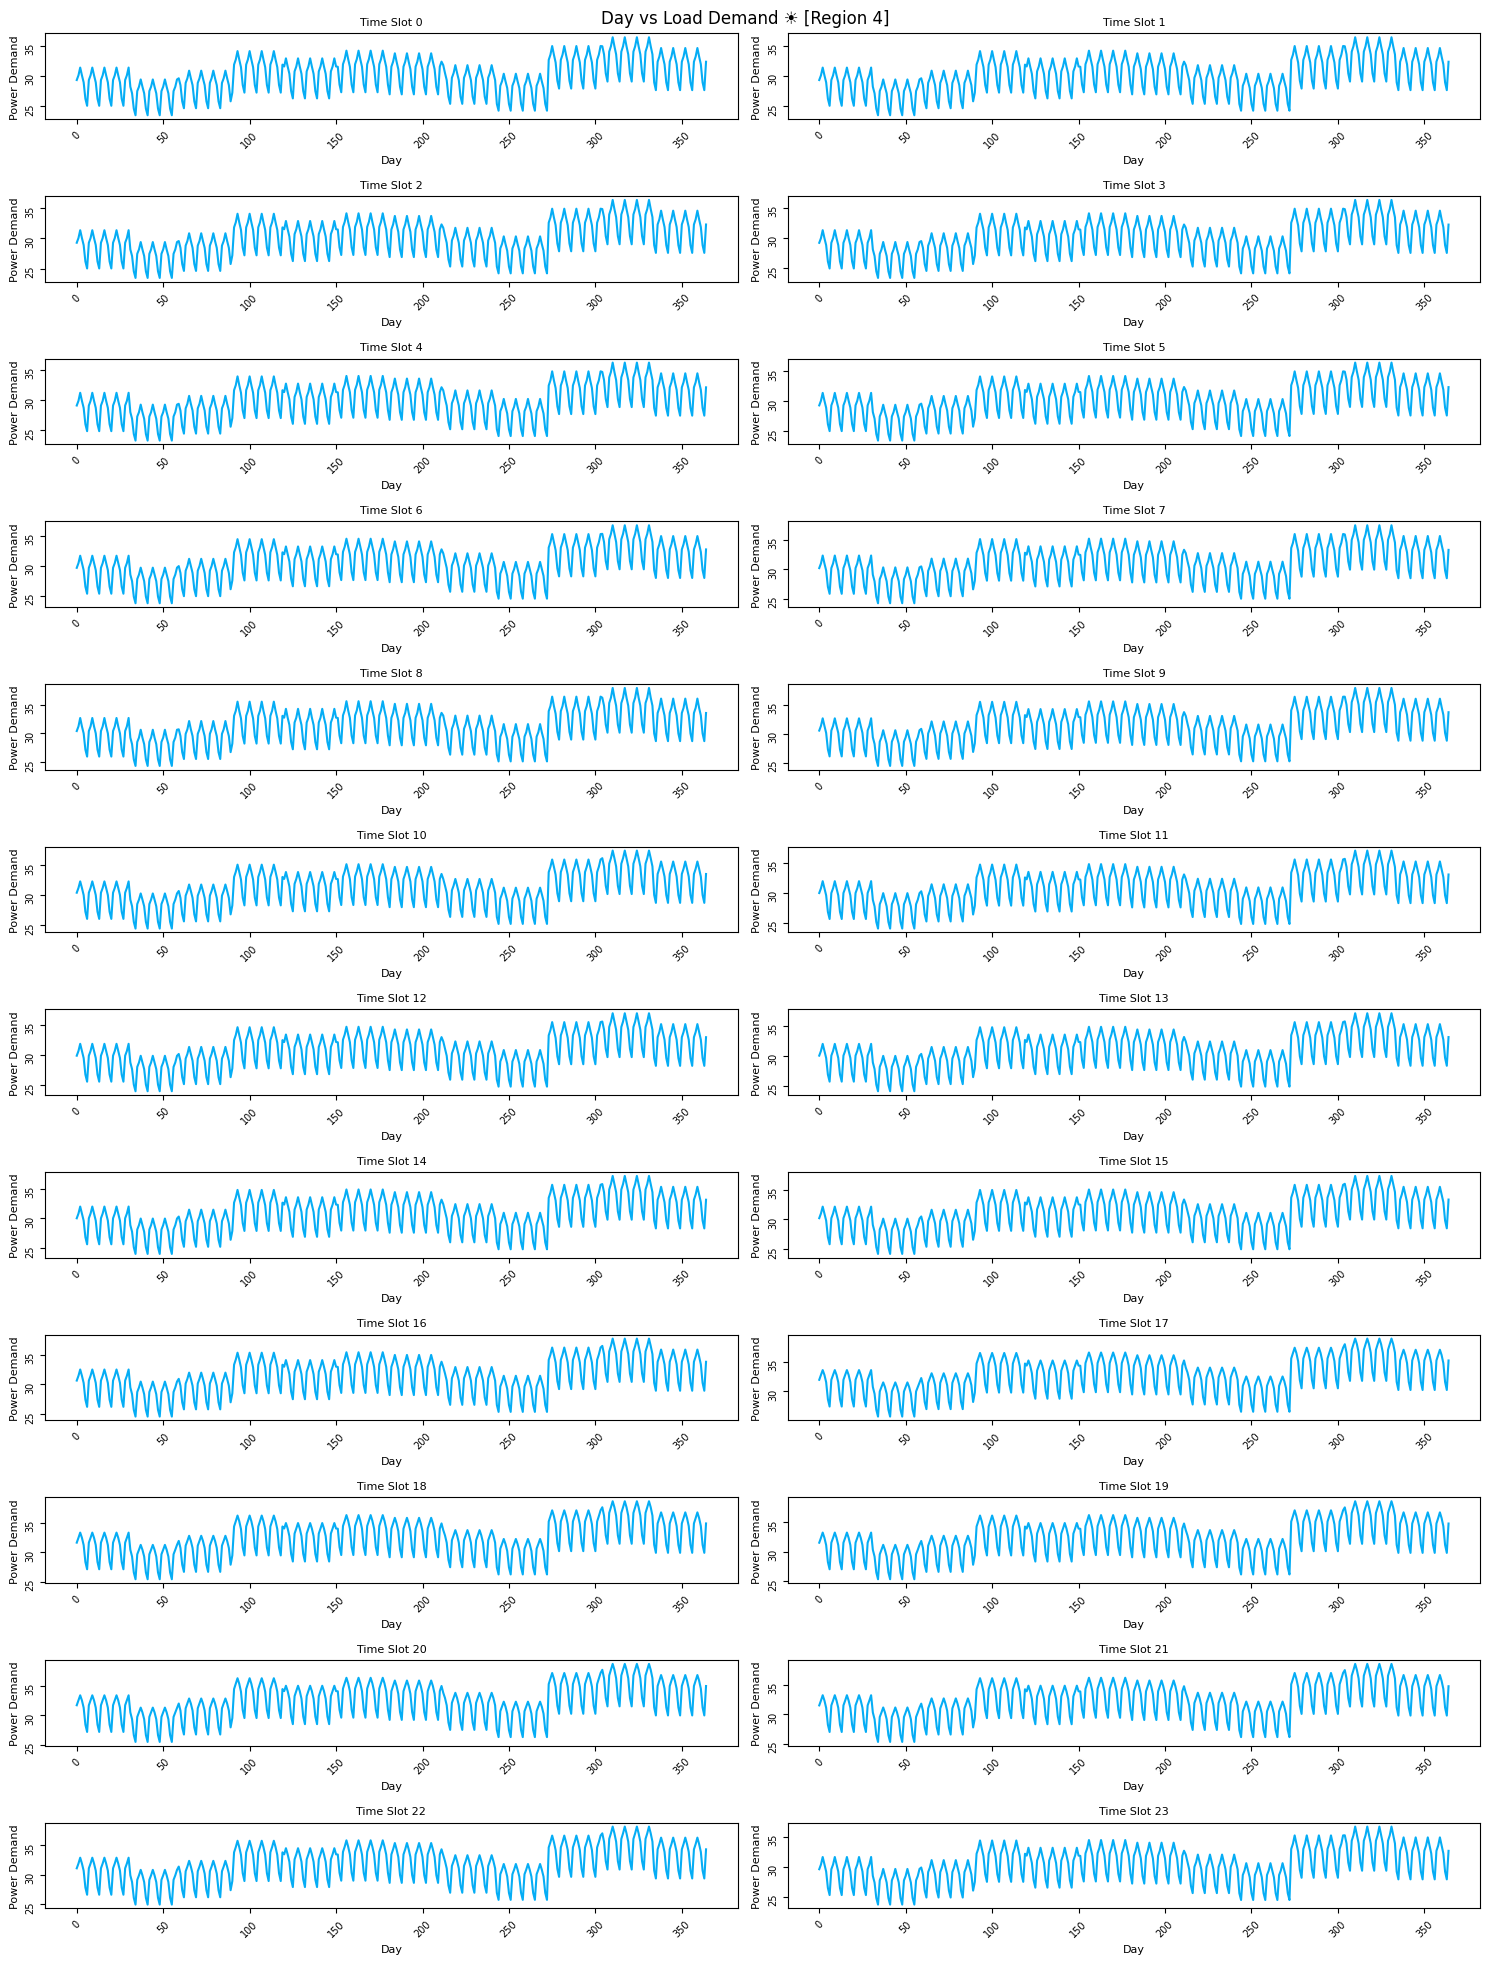

In [ ]:
viz = [plt.subplots(nrows=12, ncols=2, figsize=(15, 20)) for _ in range(len(regions))]

for v in range(len(viz)):
    fig, axes = viz[v]
    k = 0
    for i in range(12):
        for j in range(2):
            sns.lineplot(data=X_viz_list[v], x=X_viz_list[v].index, y=f'Time period {k}', ax=axes[i, j], color='#05adf5')
            axes[i,j].set_title(f'Time Slot {k}', fontsize=8)
            axes[i,j].set_xlabel('Day', fontsize=8)
            axes[i,j].set_ylabel('Power Demand', fontsize=8)
            k += 1

    for ax in axes.flat:
        ax.tick_params(axis='x', rotation=45, labelsize=7)
        ax.tick_params(axis='y', rotation=90, labelsize=7)

    fig.subplots_adjust(wspace=1, hspace=1.5)
    fig.suptitle('Day vs Load Demand ☀️ [Region '+str(v)+']')
    fig.tight_layout();

In [23]:
X_viz_list_series = [x.drop(['Region'] + regions, axis=1) for x in X_viz_list]
flattened = [pd.Series(x.values.flatten(), dtype=np.float64) for x in X_viz_list_series]

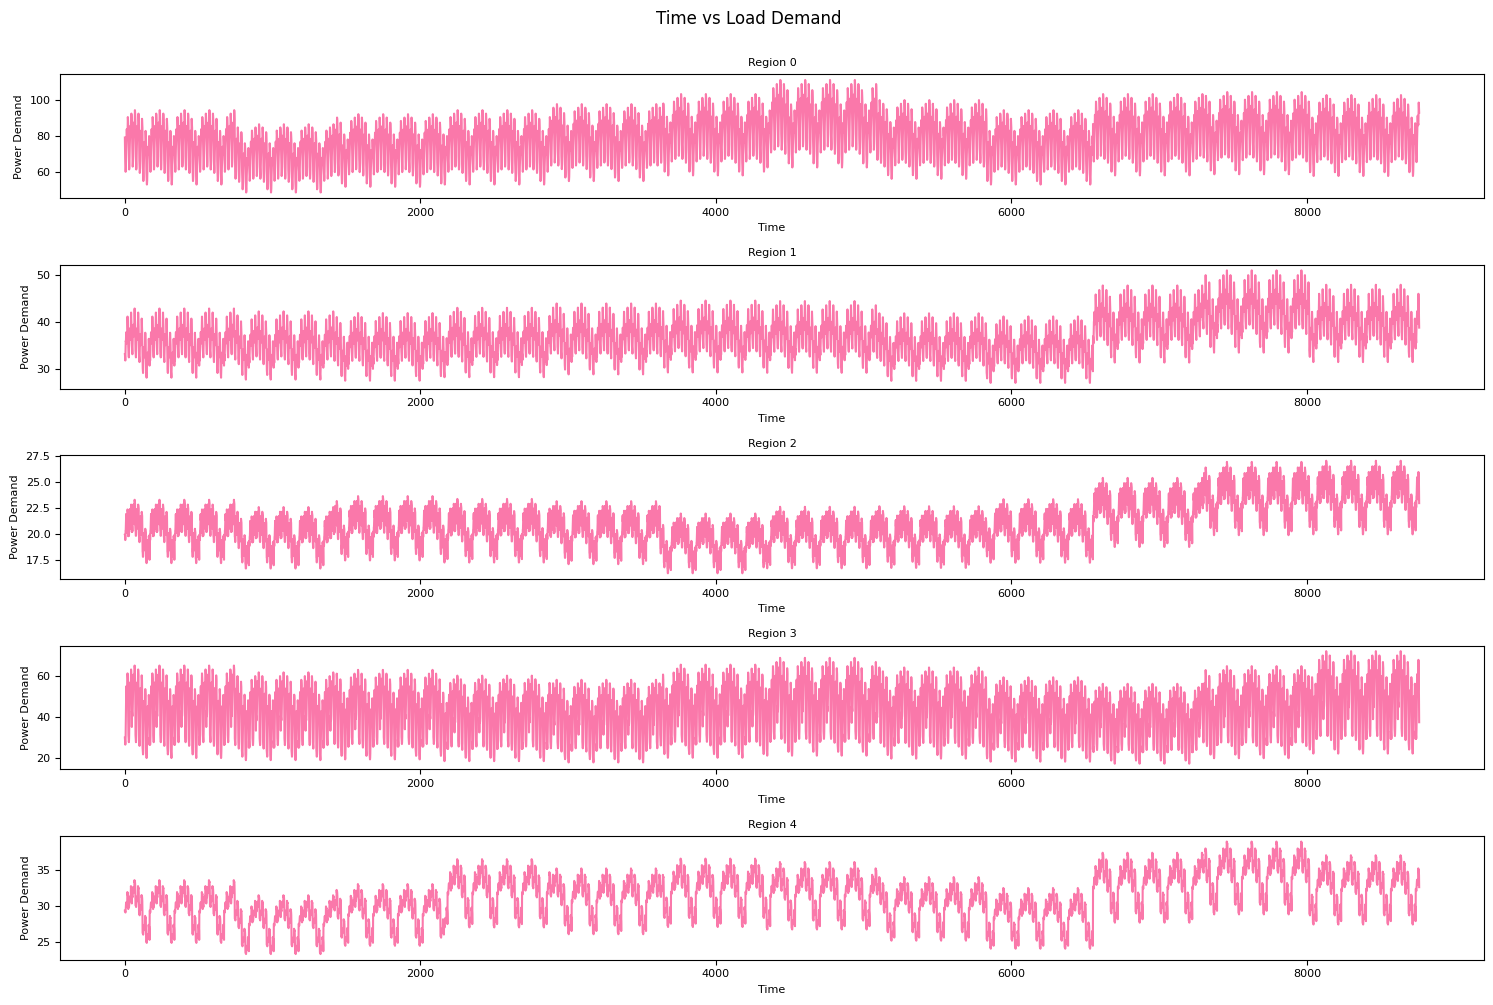

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 10))

for i in range(len(regions)):
    sns.lineplot(x=flattened[i].index, y=flattened[i], ax=axes[i], color='#fa78aa')
    axes[i].set_title(f'Region {i}', fontsize=8)
    axes[i].set_xlabel('Time', fontsize=8)
    axes[i].set_ylabel('Power Demand', fontsize=8)

for ax in axes.flat:
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

fig.subplots_adjust(wspace=1, hspace=2)
fig.suptitle('Time vs Load Demand', y=1)
fig.tight_layout();

# Training

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# By Date => Load Reading

Make records for each Time period's readings

In [24]:
X_new = df.drop(columns=['Region', 'Date', 'Minimum load level (p.u.)', 'Maximum load level (p.u.)', 'Peak-valley difference'])
X_new_list = [X_new[X_new[r] == 1].reset_index(drop=True).drop(['D1', 'D2', 'D3', 'D4', 'D5'], axis=1) for r in regions]

X_Region_1 = pd.melt(X_new_list[0], id_vars=['Year', 'Month', 'Day'], var_name='Hourly_Reading', value_name='Load')
X_Region_1['Hourly_Reading'] = X_Region_1['Hourly_Reading'].str.extract('(\d+)').astype(float)
X_Region_1 = X_Region_1.sort_values(by=['Day', 'Month', 'Year']).reset_index(drop=True).drop(['Hourly_Reading'], axis=1)

#### Add Time period column

In [25]:
X, y = X_Region_1.drop('Load', axis=1), np.array(X_Region_1['Load'])
X['Time period'] = (X.index % 24)
X = np.array(X)

#### Split the Dataset

In [33]:
X_train, y_train = X[:6000], y[:6000]
X_val, y_val = X[6000:7700], y[6000:7700]
X_test, y_test = X[7700:], y[7700:]

#### Normalizing the Dataset

In [34]:
from sklearn.preprocessing import MinMaxScaler

def normalize(X_train, X_val, X_test):
  sc = MinMaxScaler()
  X_train = sc.fit_transform(X_train)
  X_val = sc.transform(X_val)
  X_test = sc.transform(X_test)
  return X_train, X_val, X_test

#### Reshaping for passing each record per time step through NN

In [35]:
def reshaping(X_train, X_val, X_test):
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
  return X_train, X_val, X_test

In [36]:
X_train, X_val, X_test = normalize(X_train, X_val, X_test)
X_train, X_val, X_test = reshaping(X_train, X_val, X_test)

#### Model Architechture and Fitting

In [37]:
def train_show(model, X_train, y_train, X_val, y_val, epochs, batch_size, lr):
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    history = model.fit(X_train, y_train, verbose=0, epochs=epochs, batch_size=batch_size, validation_data=(X_val,y_val))

    print('MSE =', model.evaluate(X_test, y_test))
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,2))
    axes[0].plot(history.history['loss'][-30:], label='Training Loss', color='tomato')
    axes[1].plot(history.history['val_loss'][-30:], label='Validation Loss', color='green')
    plt.suptitle('Training Loss Curve                                                Validation Loss Curve');

#### Changing units

34/34 [==============================] - 0s 3ms/step - loss: 68.4048
MSE = 68.40477752685547


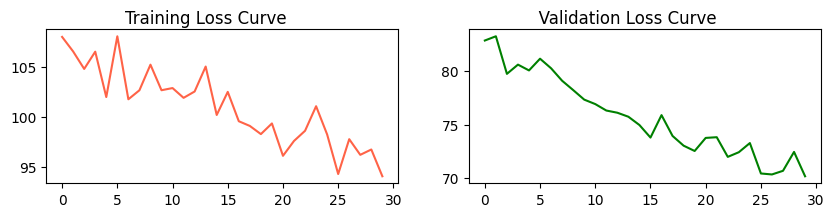

In [85]:
model = Sequential([
    LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

34/34 [==============================] - 0s 4ms/step - loss: 66.8574
MSE = 66.85737609863281


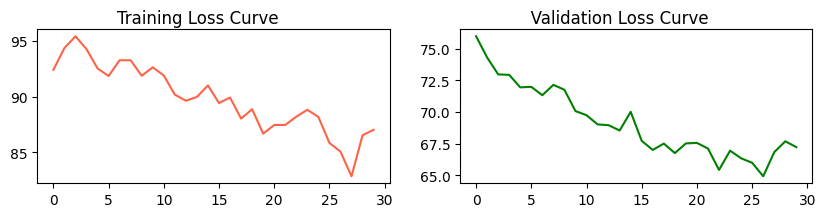

In [86]:
model = Sequential([
    LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

34/34 [==============================] - 0s 3ms/step - loss: 75.0643
MSE = 75.06434631347656


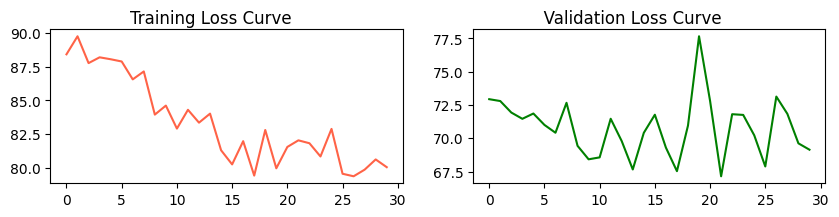

In [87]:
model = Sequential([
    LSTM(40, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

34/34 [==============================] - 0s 3ms/step - loss: 64.8897
MSE = 64.88968658447266


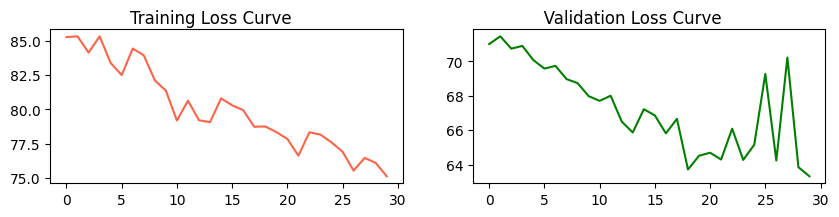

In [88]:
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

34/34 [==============================] - 0s 4ms/step - loss: 76.6594
MSE = 76.65943908691406


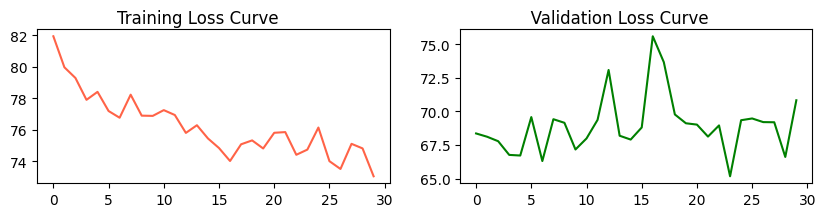

In [89]:
model = Sequential([
    LSTM(60, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

34/34 [==============================] - 0s 3ms/step - loss: 64.9617
MSE = 64.9616928100586


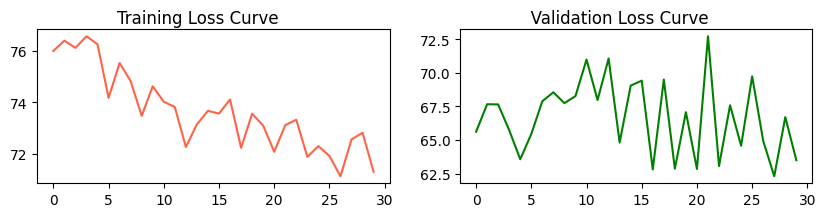

In [90]:
model = Sequential([
    LSTM(70, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

34/34 [==============================] - 0s 4ms/step - loss: 72.4807
MSE = 72.48072052001953


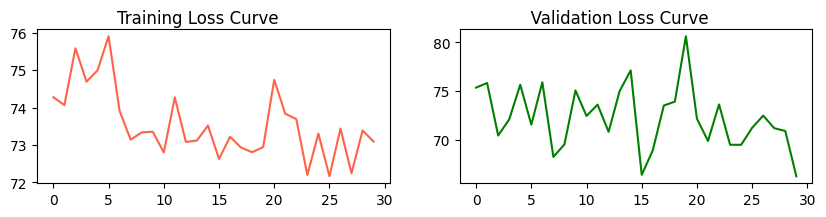

In [91]:
model = Sequential([
    LSTM(80, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

34/34 [==============================] - 0s 3ms/step - loss: 64.0282
MSE = 64.0281982421875


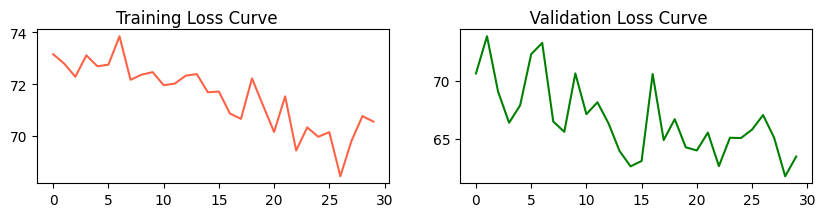

In [92]:
model = Sequential([
    LSTM(84, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

#### Changing Dropout

34/34 [==============================] - 0s 5ms/step - loss: 86.6270
MSE = 86.62702941894531


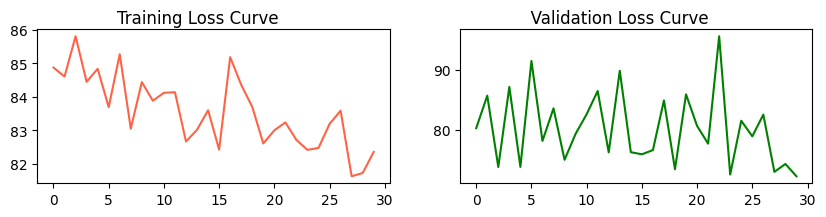

In [94]:
model = Sequential([
    LSTM(84, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

34/34 [==============================] - 0s 4ms/step - loss: 96.0236
MSE = 96.02363586425781


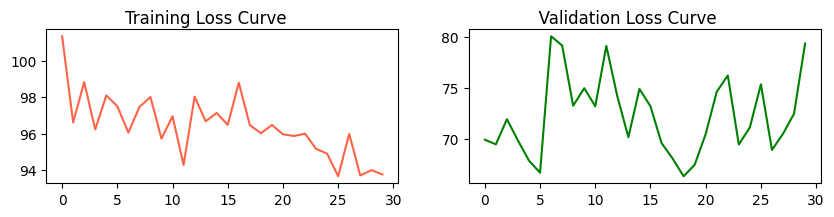

In [95]:
model = Sequential([
    LSTM(84, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

34/34 [==============================] - 0s 4ms/step - loss: 114.3187
MSE = 114.31865692138672


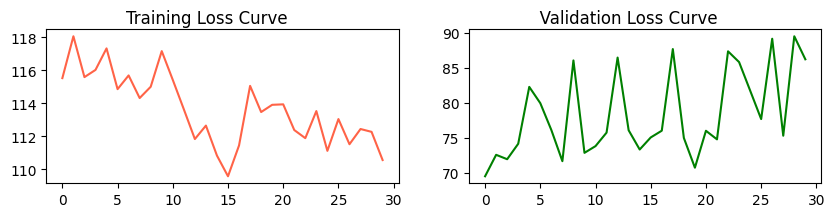

In [96]:
model = Sequential([
    LSTM(84, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.4),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

#### Changing Batch Size

34/34 [==============================] - 0s 4ms/step - loss: 62.3809
MSE = 62.38093948364258


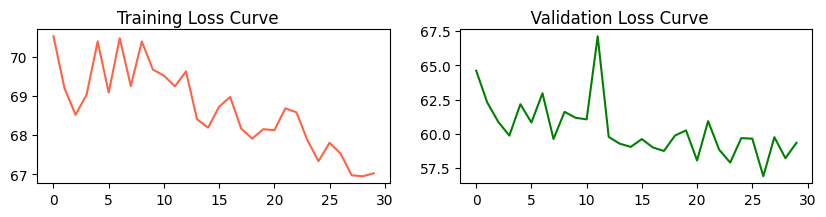

In [97]:
model = Sequential([
    LSTM(84, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=16, lr=.001)

34/34 [==============================] - 0s 3ms/step - loss: 80.5733
MSE = 80.57333374023438


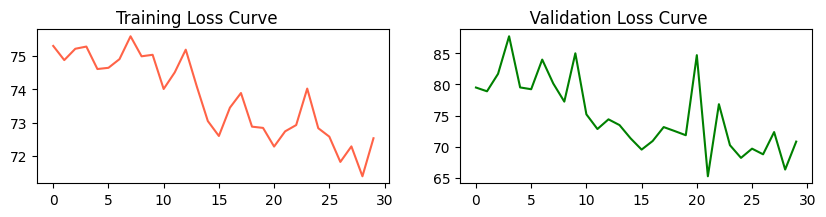

In [98]:
model = Sequential([
    LSTM(84, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

34/34 [==============================] - 0s 4ms/step - loss: 68.1003
MSE = 68.10025024414062


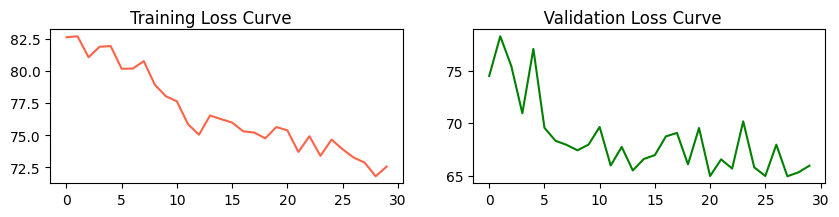

In [99]:
model = Sequential([
    LSTM(84, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=48, lr=.001)

34/34 [==============================] - 0s 3ms/step - loss: 71.2255
MSE = 71.22552490234375


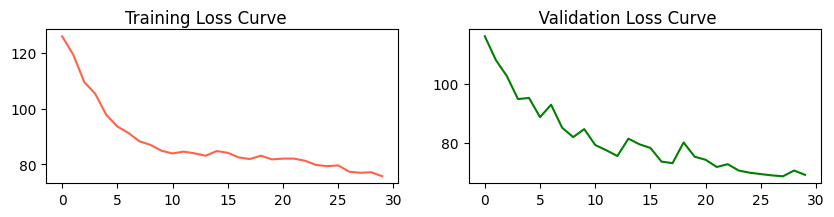

In [100]:
model = Sequential([
    LSTM(84, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=60, lr=.001)

34/34 [==============================] - 0s 3ms/step - loss: 77.8154
MSE = 77.81535339355469


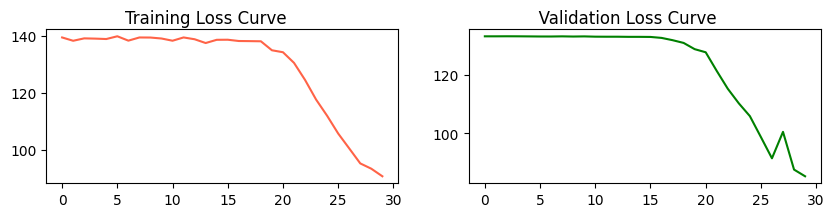

In [101]:
model = Sequential([
    LSTM(84, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=80, lr=.001)

#### Changing Layers

34/34 [==============================] - 0s 5ms/step - loss: 41.9414
MSE = 41.941410064697266


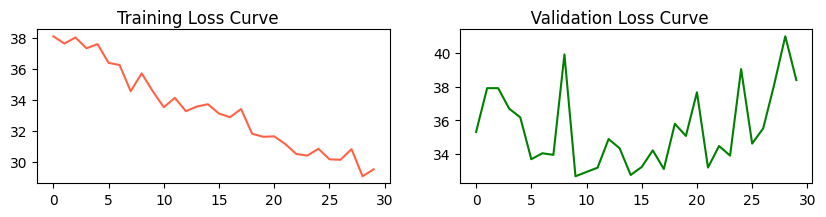

In [102]:
model = Sequential([
    LSTM(84, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.1),
    LSTM(84),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=16, lr=.001)

34/34 [==============================] - 0s 4ms/step - loss: 125.8086
MSE = 125.80862426757812


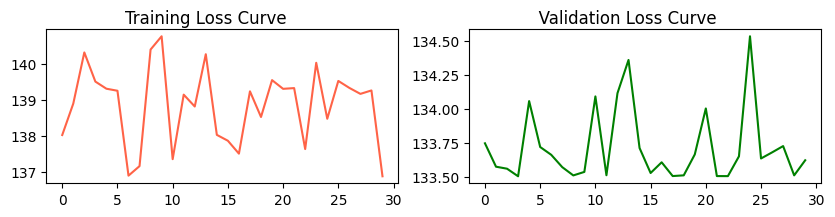

In [103]:
model = Sequential([
    LSTM(84, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.1),
    LSTM(84, return_sequences=True),
    Dropout(0.1),
    LSTM(84),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=16, lr=.001)

34/34 [==============================] - 0s 7ms/step - loss: 126.6639
MSE = 126.66387176513672


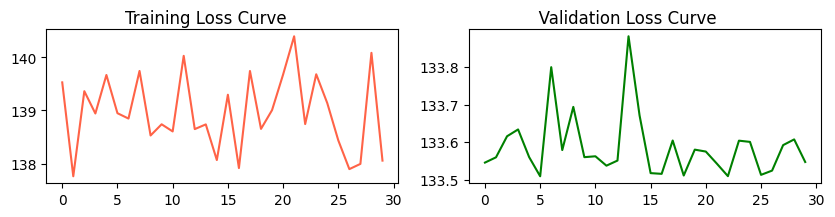

In [104]:
model = Sequential([
    LSTM(84, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.1),
    LSTM(84, return_sequences=True),
    Dropout(0.1),
    LSTM(84, return_sequences=True),
    Dropout(0.1),
    LSTM(84),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=16, lr=.001)

#### Changing Hidden units

34/34 [==============================] - 0s 5ms/step - loss: 31.3994
MSE = 31.399377822875977


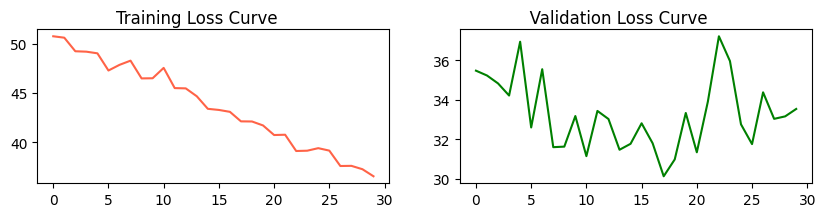

In [105]:
model = Sequential([
    LSTM(84, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.1),
    LSTM(50),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=16, lr=.001)

34/34 [==============================] - 0s 6ms/step - loss: 30.9462
MSE = 30.946197509765625


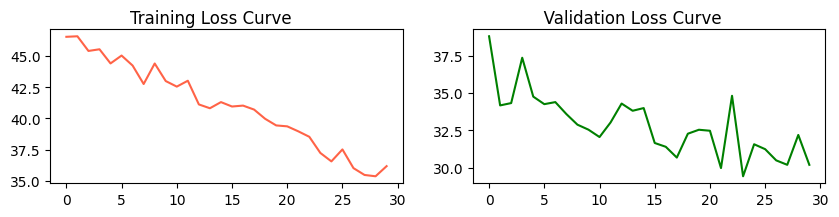

In [106]:
model = Sequential([
    LSTM(84, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.1),
    LSTM(60),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=16, lr=.001)

34/34 [==============================] - 0s 5ms/step - loss: 46.6147
MSE = 46.61474609375


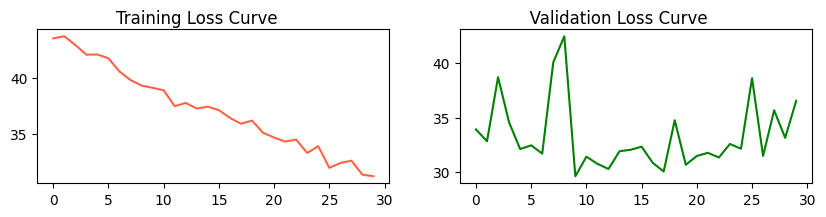

In [107]:
model = Sequential([
    LSTM(84, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.1),
    LSTM(int(2*84/3) + 1),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=16, lr=.001)

34/34 [==============================] - 0s 5ms/step - loss: 30.4175
MSE = 30.417470932006836


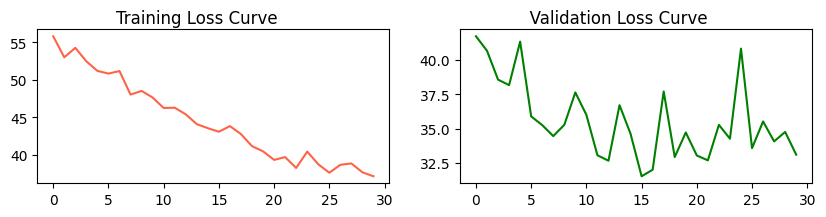

In [108]:
model = Sequential([
    LSTM(84, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.1),
    LSTM(40),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=16, lr=.001)

#### Finalizing Hyperparameters and training

84 units, 0.1 dropout, 16 batch_size, 2 layers, 40 hidden units

In [109]:
checkpoint = ModelCheckpoint('best_date_load.keras',
                                monitor='val_loss',
                                save_best_only=True,
                                mode='min')

In [110]:
model = Sequential([
    LSTM(84, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.1),
    LSTM(40),
    Dropout(0.1),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=.001), loss='mse')
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val,y_val), \
                callbacks=[checkpoint])

Epoch 1/100
375/375 [==============================] - 7s 11ms/step - loss: 4103.8760 - val_loss: 3044.3018
Epoch 2/100
375/375 [==============================] - 3s 8ms/step - loss: 2363.5066 - val_loss: 1789.9835
Epoch 3/100
375/375 [==============================] - 3s 8ms/step - loss: 1362.4348 - val_loss: 1004.3019
Epoch 4/100
375/375 [==============================] - 3s 8ms/step - loss: 752.2335 - val_loss: 544.9926
Epoch 5/100
375/375 [==============================] - 3s 8ms/step - loss: 415.8877 - val_loss: 302.6981
Epoch 6/100
375/375 [==============================] - 3s 8ms/step - loss: 248.9086 - val_loss: 192.1942
Epoch 7/100
375/375 [==============================] - 3s 8ms/step - loss: 175.8459 - val_loss: 150.3672
Epoch 8/100
375/375 [==============================] - 3s 8ms/step - loss: 154.5598 - val_loss: 137.5866
Epoch 9/100
375/375 [==============================] - 3s 8ms/step - loss: 149.5975 - val_loss: 134.3598
Epoch 10/100
375/375 [==========================

Retraining the model for more epochs

In [111]:
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch, lr):
    if epoch % 100 == 0 and epoch!=0:
      lr *= 0.1
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

In [116]:
from keras.models import load_model
model = load_model('best_date_load.keras')
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
history = model.fit(X_train, y_train, epochs=1000, batch_size=16, validation_data=(X_val,y_val), \
                callbacks=[checkpoint, lr_scheduler])

Epoch 1/1000
375/375 [==============================] - 6s 9ms/step - loss: 61.1817 - val_loss: 47.7040 - lr: 0.0100
Epoch 2/1000
375/375 [==============================] - 3s 7ms/step - loss: 57.8961 - val_loss: 64.4417 - lr: 0.0100
Epoch 3/1000
375/375 [==============================] - 3s 8ms/step - loss: 58.2003 - val_loss: 55.6800 - lr: 0.0100
Epoch 4/1000
375/375 [==============================] - 3s 9ms/step - loss: 54.5408 - val_loss: 51.3778 - lr: 0.0100
Epoch 5/1000
375/375 [==============================] - 3s 7ms/step - loss: 52.5262 - val_loss: 63.8721 - lr: 0.0100
Epoch 6/1000
375/375 [==============================] - 3s 8ms/step - loss: 49.8985 - val_loss: 41.5916 - lr: 0.0100
Epoch 7/1000
375/375 [==============================] - 3s 8ms/step - loss: 48.0527 - val_loss: 37.4711 - lr: 0.0100
Epoch 8/1000
375/375 [==============================] - 3s 8ms/step - loss: 46.6481 - val_loss: 41.4426 - lr: 0.0100
Epoch 9/1000
375/375 [==============================] - 3s 8ms/s

KeyboardInterrupt: 

# Windowed series => Current Reading

# Region 1

Creating sequences of Data
*   [1,2,3,4,5] => [6]
*   [2,3,4,5,6] => [7]
*   [3,4,5,6,7] => [8]

In [38]:
def flattened_to_matrix(flat, window_size):
  X, y = [], []
  for i in range(len(flat) - window_size):
    row = [[x] for x in flat[i : i+window_size]]
    X.append(row)
    y.append(flat[i+window_size])
  return X,y

In [39]:
def windowing(arr, window_size):
  X, y = flattened_to_matrix(arr, window_size)
  X, y = np.array(X), np.array(y)

  a = X.shape[0]
  X_train, y_train = X[:int(0.8*a)], y[:int(0.8*a)]
  X_val, y_val = X[int(0.8*a):int(0.9*a)], y[int(0.8*a):int(0.9*a)]
  X_test, y_test = X[int(0.9*a):], y[int(0.9*a):]
  return X_train, y_train, X_val, y_val, X_test, y_test

#### Changing units

28/28 [==============================] - 0s 9ms/step - loss: 7.7258
MSE = 7.725772380828857


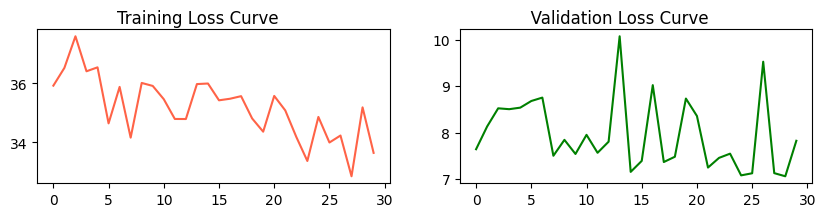

In [35]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 24)

model = Sequential([
    LSTM(20, input_shape=(X_train.shape[1], 1)),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

28/28 [==============================] - 0s 10ms/step - loss: 3.4386
MSE = 3.4386234283447266


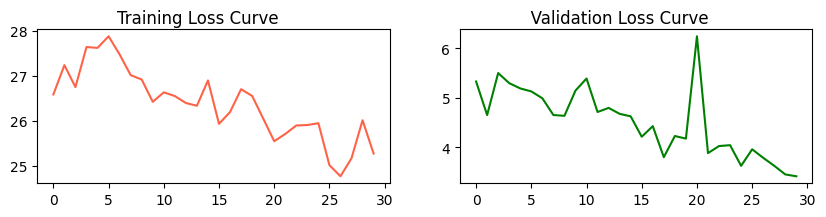

In [36]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 24)

model = Sequential([
    LSTM(30, input_shape=(X_train.shape[1], 1)),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

28/28 [==============================] - 0s 5ms/step - loss: 3.2102
MSE = 3.2101614475250244


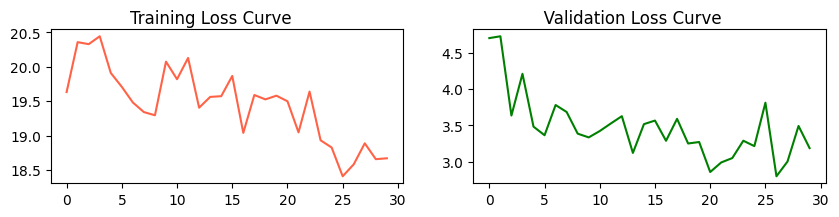

In [37]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 24)

model = Sequential([
    LSTM(40, input_shape=(X_train.shape[1], 1)),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

28/28 [==============================] - 0s 7ms/step - loss: 2.9171
MSE = 2.917057514190674


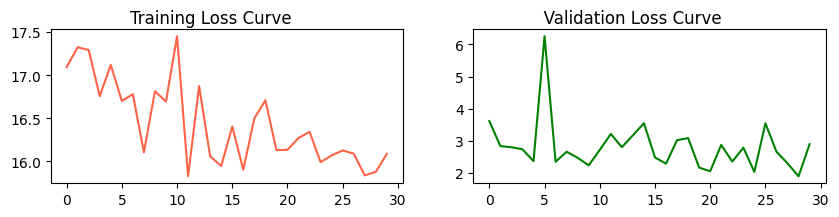

In [38]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 24)

model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], 1)),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

28/28 [==============================] - 0s 9ms/step - loss: 2.0600
MSE = 2.059966564178467


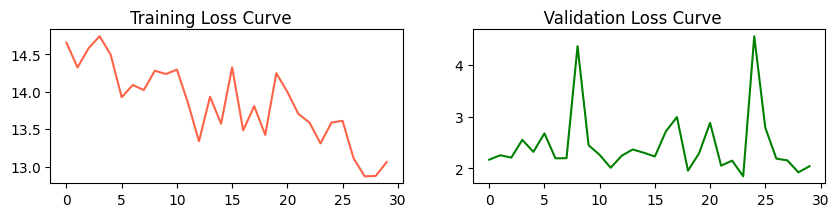

In [39]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 24)

model = Sequential([
    LSTM(60, input_shape=(X_train.shape[1], 1)),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

28/28 [==============================] - 0s 7ms/step - loss: 1.9163
MSE = 1.9162765741348267


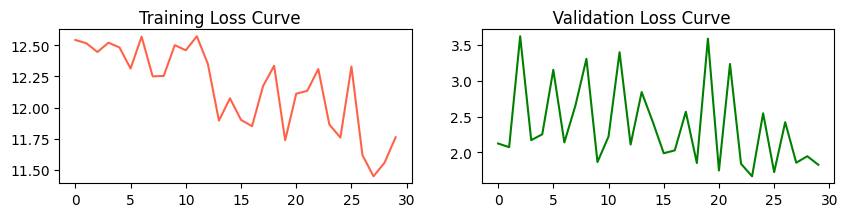

In [41]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 24)

model = Sequential([
    LSTM(70, input_shape=(X_train.shape[1], 1)),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

28/28 [==============================] - 0s 7ms/step - loss: 1.9936
MSE = 1.9935981035232544


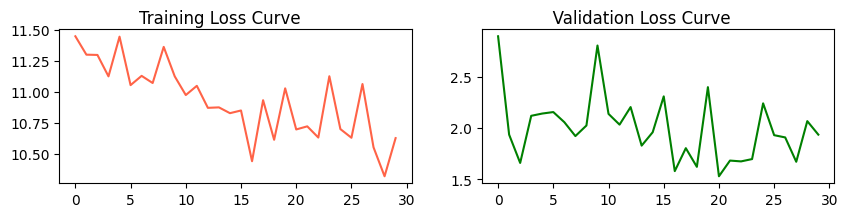

In [42]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 24)

model = Sequential([
    LSTM(80, input_shape=(X_train.shape[1], 1)),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

28/28 [==============================] - 0s 8ms/step - loss: 1.9239
MSE = 1.9239344596862793


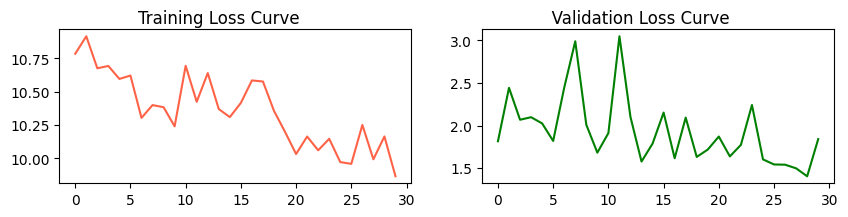

In [43]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 24)

model = Sequential([
    LSTM(84, input_shape=(X_train.shape[1], 1)),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

#### Changing Dropout

28/28 [==============================] - 0s 7ms/step - loss: 4.1909
MSE = 4.190938472747803


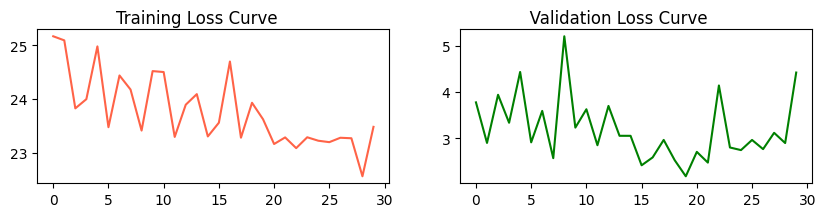

In [44]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 24)

model = Sequential([
    LSTM(70, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

28/28 [==============================] - 0s 7ms/step - loss: 3.4333
MSE = 3.433285713195801


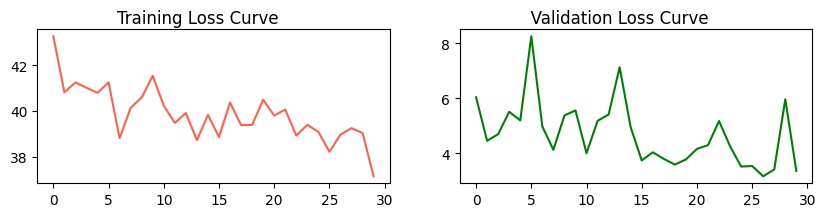

In [45]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 24)

model = Sequential([
    LSTM(70, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),                                        
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

28/28 [==============================] - 0s 7ms/step - loss: 4.3379
MSE = 4.33791446685791


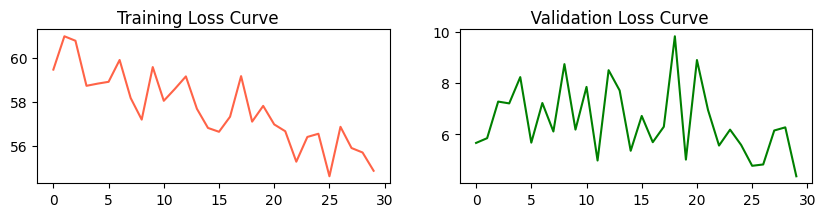

In [46]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 24)

model = Sequential([
    LSTM(70, input_shape=(X_train.shape[1], 1)),            
    Dropout(0.4),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

#### Changing Batch Size

28/28 [==============================] - 0s 7ms/step - loss: 1.8175
MSE = 1.8174655437469482


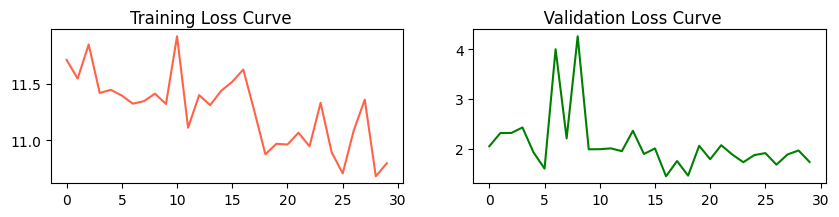

In [47]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 24)

model = Sequential([
    LSTM(70, input_shape=(X_train.shape[1], 1)),
    Dropout(0.1),                                           
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=16, lr=.001)

28/28 [==============================] - 0s 7ms/step - loss: 1.8611
MSE = 1.861096739768982


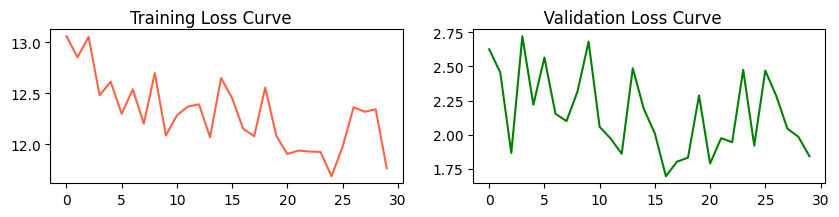

In [48]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 24)

model = Sequential([
    LSTM(70, input_shape=(X_train.shape[1], 1)),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=.001)

28/28 [==============================] - 0s 7ms/step - loss: 2.1550
MSE = 2.1550004482269287


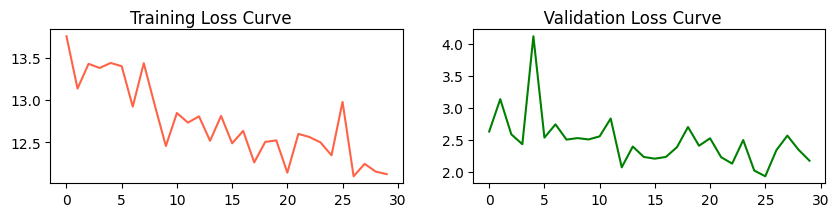

In [49]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 24)

model = Sequential([
    LSTM(70, input_shape=(X_train.shape[1], 1)),        
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=48, lr=.001)

28/28 [==============================] - 0s 11ms/step - loss: 1.9728
MSE = 1.9728035926818848


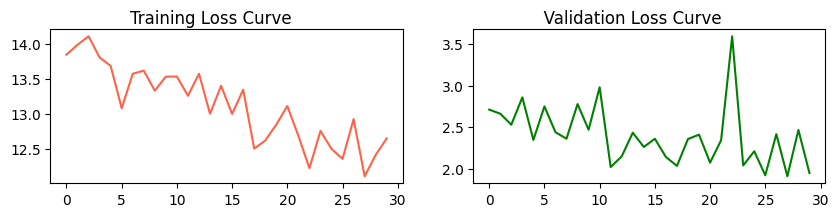

In [50]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 24)

model = Sequential([
    LSTM(70, input_shape=(X_train.shape[1], 1)),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=60, lr=.001)

#### Changing Window size

28/28 [==============================] - 0s 12ms/step - loss: 2.4837
MSE = 2.4836769104003906


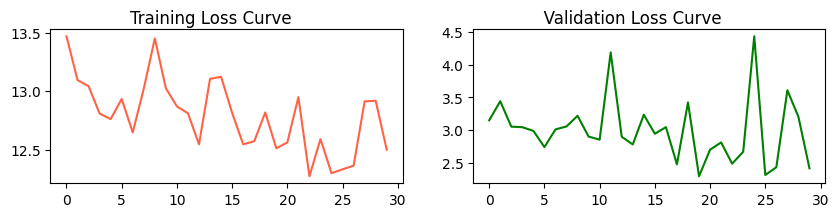

In [53]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 48)

model = Sequential([
    LSTM(70, input_shape=(X_train.shape[1], 1)),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=16, lr=.001)

28/28 [==============================] - 0s 14ms/step - loss: 1.6311
MSE = 1.631056785583496


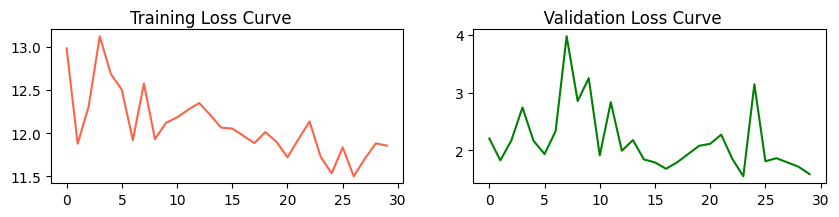

In [54]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 60)

model = Sequential([
    LSTM(70, input_shape=(X_train.shape[1], 1)),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=16, lr=.001)

28/28 [==============================] - 0s 17ms/step - loss: 2.6383
MSE = 2.6383461952209473


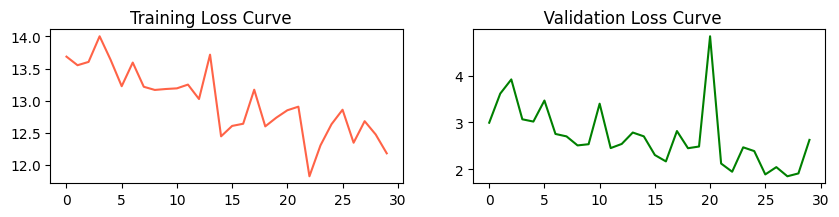

In [55]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 84)

model = Sequential([
    LSTM(70, input_shape=(X_train.shape[1], 1)),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=16, lr=.001)

#### Changing Layers

28/28 [==============================] - 1s 50ms/step - loss: 2.0912
MSE = 2.0912320613861084


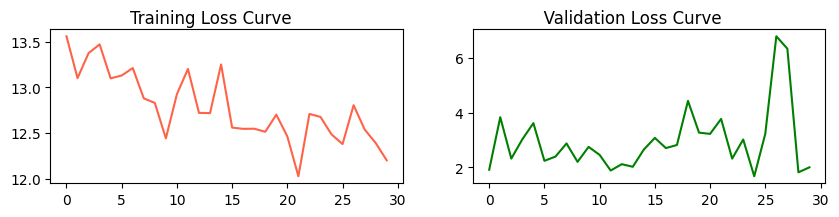

In [57]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 60)

model = Sequential([
    LSTM(70, input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.1),
    LSTM(70),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=16, lr=.001)

28/28 [==============================] - 1s 30ms/step - loss: 2.2193
MSE = 2.2193219661712646


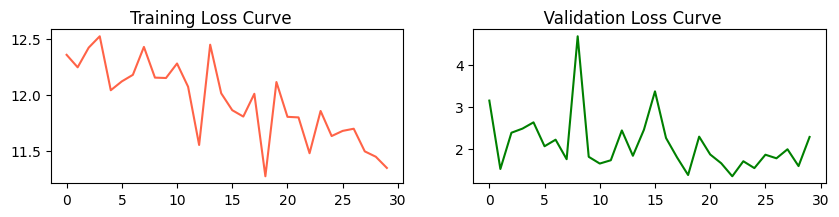

In [58]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 60)

model = Sequential([
    LSTM(70, input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.1),
    LSTM(70, return_sequences=True),
    Dropout(0.1),
    LSTM(70),
    Dropout(0.1),
    Dense(1)
])

train_show(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=16, lr=.001)

### Finalizing Hyperparameters and training

70 units, 0.1 dropout, 16 batch_size, 60 window_size, 1 layer

In [89]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 60)

model = Sequential([
    LSTM(70, input_shape=(X_train.shape[1], 1)),
    Dropout(0.1),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate = .001), loss='mse')
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val,y_val))

Epoch 1/100
435/435 [==============================] - 13s 25ms/step - loss: 3550.2490 - val_loss: 2522.9065
Epoch 2/100
435/435 [==============================] - 9s 22ms/step - loss: 1342.1196 - val_loss: 1037.8688
Epoch 3/100
435/435 [==============================] - 9s 22ms/step - loss: 501.1543 - val_loss: 430.6966
Epoch 4/100
435/435 [==============================] - 9s 22ms/step - loss: 217.6268 - val_loss: 213.7761
Epoch 5/100
435/435 [==============================] - 9s 21ms/step - loss: 105.5003 - val_loss: 87.5448
Epoch 6/100
435/435 [==============================] - 11s 24ms/step - loss: 50.5112 - val_loss: 44.3551
Epoch 7/100
435/435 [==============================] - 10s 23ms/step - loss: 35.9128 - val_loss: 27.2484
Epoch 8/100
435/435 [==============================] - 9s 21ms/step - loss: 28.6532 - val_loss: 21.5857
Epoch 9/100
435/435 [==============================] - 9s 21ms/step - loss: 23.9813 - val_loss: 14.9861
Epoch 10/100
435/435 [==========================

#### Retraining the model for more epochs

In [18]:
checkpoint = ModelCheckpoint('best_time_series_load_4.keras',
                                monitor='val_loss',
                                save_best_only=True,
                                mode='min')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
flattened_scaled = scaler.fit_transform(flattened[0].values.reshape(-1, 1)).flatten()

X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened_scaled, 60)

In [27]:
from keras.models import load_model
model = load_model('best_time_series_load_4.keras')
model.compile(optimizer=Adam(learning_rate = 0.000001), loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val,y_val), callbacks=[checkpoint])

Epoch 1/10
435/435 [==============================] - 11s 21ms/step - loss: 2.4192 - val_loss: 0.0050
Epoch 2/10
435/435 [==============================] - 9s 21ms/step - loss: 2.3163 - val_loss: 0.0050
Epoch 3/10
435/435 [==============================] - 9s 21ms/step - loss: 2.3764 - val_loss: 0.0052
Epoch 4/10
435/435 [==============================] - 9s 22ms/step - loss: 2.4208 - val_loss: 0.0054
Epoch 5/10
435/435 [==============================] - 9s 21ms/step - loss: 2.3446 - val_loss: 0.0055
Epoch 6/10
435/435 [==============================] - 9s 21ms/step - loss: 2.3997 - val_loss: 0.0054
Epoch 7/10
435/435 [==============================] - 9s 22ms/step - loss: 2.3279 - val_loss: 0.0060
Epoch 8/10
435/435 [==============================] - 10s 22ms/step - loss: 2.4186 - val_loss: 0.0058
Epoch 9/10
435/435 [==============================] - 9s 21ms/step - loss: 2.4166 - val_loss: 0.0056
Epoch 10/10
435/435 [==============================] - 10s 22ms/step - loss: 2.4111 - val

# Predictions

In [31]:
y_pred = model.predict(X_test)
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

28/28 [==============================] - 0s 17ms/step


In [36]:
y_pred_plot = y_pred_original
y_test_plot = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

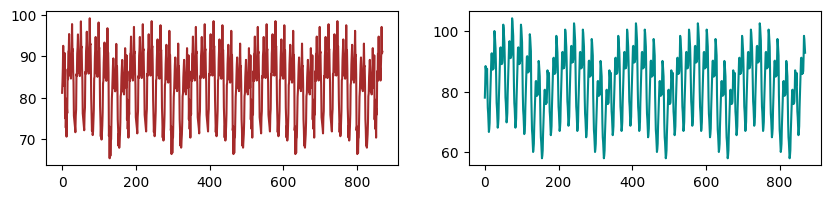

In [42]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,2))
sns.lineplot(y_pred_plot, color='brown', ax=axes[0]);
sns.lineplot(y_test_plot, color='darkcyan', ax=axes[1]);

# SVM Regressor

In [38]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 48)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

X_train, X_val, X_test = normalize(X_train, X_val, X_test)

In [36]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

def train_svm(kernel, C, epsilon, X_train, y_train, X_test, y_test):
    model = SVR(kernel=kernel, C=C, epsilon=epsilon)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

#### Changing kernel

In [147]:
train_svm(kernel='rbf', C=1, epsilon=0.1, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

1.3621111294733186

In [148]:
train_svm(kernel='linear', C=1, epsilon=0.1, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

2.0525273085191746

In [149]:
train_svm(kernel='poly', C=1, epsilon=0.1, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

0.9654378425809612

#### Changing C

In [150]:
train_svm(kernel='poly', C=0.1, epsilon=0.1, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

2.124738789822753

In [151]:
train_svm(kernel='poly', C=0.5, epsilon=0.1, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

1.1989605368439238

In [152]:
train_svm(kernel='poly', C=2, epsilon=0.1, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

0.7803857610991408

In [ ]:
train_svm(kernel='poly', C=25, epsilon=0.1, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

#### Changing epsilon

In [153]:
train_svm(kernel='poly', C=1, epsilon=0.5, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

0.9614256658308085

In [154]:
train_svm(kernel='poly', C=0.1, epsilon=0.6, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

2.0338757086974173

In [155]:
train_svm(kernel='poly', C=0.1, epsilon=1, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

2.1453778863901474

# GRU

In [111]:
checkpoint = ModelCheckpoint('best_gru_load_2.keras',
                                monitor='val_loss',
                                save_best_only=True,
                                mode='min')

In [112]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 60)

model = Sequential([
    GRU(70, input_shape=(X_train.shape[1], 1)),
    Dropout(0.1),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=.001), loss='mse')
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val,y_val), callbacks=[checkpoint])

Epoch 1/100
435/435 [==============================] - 15s 24ms/step - loss: 3414.2534 - val_loss: 2272.8381
Epoch 2/100
435/435 [==============================] - 10s 22ms/step - loss: 1113.6348 - val_loss: 799.9257
Epoch 3/100
435/435 [==============================] - 8s 19ms/step - loss: 360.0296 - val_loss: 302.6063
Epoch 4/100
435/435 [==============================] - 8s 19ms/step - loss: 136.8292 - val_loss: 129.3115
Epoch 5/100
435/435 [==============================] - 8s 19ms/step - loss: 65.7216 - val_loss: 64.3774
Epoch 6/100
435/435 [==============================] - 8s 19ms/step - loss: 40.1995 - val_loss: 37.0757
Epoch 7/100
435/435 [==============================] - 8s 19ms/step - loss: 30.6780 - val_loss: 22.8563
Epoch 8/100
435/435 [==============================] - 8s 19ms/step - loss: 25.4763 - val_loss: 15.5511
Epoch 9/100
435/435 [==============================] - 9s 20ms/step - loss: 21.9375 - val_loss: 14.0684
Epoch 10/100
435/435 [=============================

In [120]:
from keras.models import load_model
model = load_model('best_gru_load_2.keras')
model.compile(optimizer=Adam(learning_rate=.00001), loss='mse')
history = model.fit(X_train, y_train, epochs=1000, batch_size=16, validation_data=(X_val,y_val), callbacks=[checkpoint])

Epoch 1/1000
435/435 [==============================] - 25s 31ms/step - loss: 9.4940 - val_loss: 0.4923
Epoch 2/1000
435/435 [==============================] - 10s 22ms/step - loss: 9.4663 - val_loss: 0.4949
Epoch 3/1000
435/435 [==============================] - 10s 23ms/step - loss: 9.4570 - val_loss: 0.5059
Epoch 4/1000
435/435 [==============================] - 8s 19ms/step - loss: 9.3689 - val_loss: 0.5884
Epoch 5/1000
435/435 [==============================] - 8s 19ms/step - loss: 9.2746 - val_loss: 0.5460
Epoch 6/1000
435/435 [==============================] - 8s 19ms/step - loss: 9.5031 - val_loss: 0.8329
Epoch 7/1000
435/435 [==============================] - 9s 20ms/step - loss: 9.1405 - val_loss: 0.5156
Epoch 8/1000
435/435 [==============================] - 8s 19ms/step - loss: 9.4793 - val_loss: 0.4780
Epoch 9/1000
435/435 [==============================] - 8s 19ms/step - loss: 9.6892 - val_loss: 0.4838
Epoch 10/1000
435/435 [==============================] - 8s 20ms/step 

# RNN

In [121]:
checkpoint = ModelCheckpoint('best_rnn_load_2.keras',
                                monitor='val_loss',
                                save_best_only=True,
                                mode='min')

In [122]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(flattened[0], 60)

model = Sequential([
    SimpleRNN(70, input_shape=(X_train.shape[1], 1)),
    Dropout(0.1),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=.001), loss='mse')
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_val,y_val), callbacks=[checkpoint])

Epoch 1/200
435/435 [==============================] - 10s 13ms/step - loss: 3737.2498 - val_loss: 2685.9790
Epoch 2/200
435/435 [==============================] - 5s 11ms/step - loss: 1386.5875 - val_loss: 1012.3032
Epoch 3/200
435/435 [==============================] - 5s 11ms/step - loss: 467.3120 - val_loss: 384.1109
Epoch 4/200
435/435 [==============================] - 5s 11ms/step - loss: 181.3153 - val_loss: 168.9801
Epoch 5/200
435/435 [==============================] - 5s 11ms/step - loss: 82.3702 - val_loss: 82.2929
Epoch 6/200
435/435 [==============================] - 5s 11ms/step - loss: 48.4124 - val_loss: 45.2443
Epoch 7/200
435/435 [==============================] - 5s 11ms/step - loss: 34.3924 - val_loss: 27.6332
Epoch 8/200
435/435 [==============================] - 5s 11ms/step - loss: 27.5847 - val_loss: 18.9190
Epoch 9/200
435/435 [==============================] - 5s 11ms/step - loss: 23.9580 - val_loss: 13.5951
Epoch 10/200
435/435 [=============================

In [123]:
from keras.models import load_model
model = load_model('best_rnn_load_2.keras')
model.compile(optimizer=Adam(learning_rate=.00001), loss='mse')
history = model.fit(X_train, y_train, epochs=1000, batch_size=16, validation_data=(X_val,y_val), callbacks=[checkpoint])

Epoch 1/1000
435/435 [==============================] - 9s 13ms/step - loss: 11.3617 - val_loss: 1.8058
Epoch 2/1000
435/435 [==============================] - 5s 11ms/step - loss: 11.4040 - val_loss: 1.7221
Epoch 3/1000
435/435 [==============================] - 5s 11ms/step - loss: 11.2546 - val_loss: 1.7027
Epoch 4/1000
435/435 [==============================] - 5s 11ms/step - loss: 11.5442 - val_loss: 1.5910
Epoch 5/1000
435/435 [==============================] - 5s 11ms/step - loss: 10.7974 - val_loss: 1.5695
Epoch 6/1000
435/435 [==============================] - 5s 11ms/step - loss: 10.8068 - val_loss: 1.5692
Epoch 7/1000
435/435 [==============================] - 5s 11ms/step - loss: 10.9634 - val_loss: 1.5748
Epoch 8/1000
435/435 [==============================] - 5s 11ms/step - loss: 10.8593 - val_loss: 1.5399
Epoch 9/1000
435/435 [==============================] - 5s 11ms/step - loss: 10.9764 - val_loss: 1.5173
Epoch 10/1000
435/435 [==============================] - 5s 11ms

KeyboardInterrupt: 

# Gradient Boosted Trees

In [115]:
from sklearn.ensemble import GradientBoostingRegressor

def train_gbt(n_estimators, lr, depth, X_train, y_train, X_test, y_test):
    model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=lr, max_depth=depth)
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

#### Changing Estimators

In [116]:
train_gbt(n_estimators=100, lr=.001, depth=10, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

0.037117176457049705

In [117]:
train_gbt(n_estimators=150, lr=.001, depth=10, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

0.12731367480582734

In [118]:
train_gbt(n_estimators=200, lr=.001, depth=10, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

0.2087086337514793

In [125]:
train_gbt(n_estimators=500, lr=.001, depth=10, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

0.5566392743831348

#### Changing Depth

In [121]:
train_gbt(n_estimators=250, lr=.001, depth=3, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

0.25258463968749845

In [122]:
train_gbt(n_estimators=250, lr=.001, depth=4, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

0.2633330639942645

In [123]:
train_gbt(n_estimators=250, lr=.001, depth=5, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

0.2682707890236793

In [124]:
train_gbt(n_estimators=250, lr=.001, depth=6, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

0.2741449859162689